<a href="https://colab.research.google.com/github/erlenman/SOS/blob/master/ActFun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
import numpy as np
import pandas as pd
import random

In [0]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

# Define layers

In [0]:
from tensorflow.python.keras.utils import tf_utils

In [0]:
class poly_relu(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
      super(poly_relu, self).__init__(**kwargs)

    def build(self, input_shape):
      self.alpha = self.add_weight(
          shape=(3,input_shape[-1]),
          name='alpha',
          trainable=True)
      self.beta = self.add_weight(
          shape=(3,input_shape[-1]),
          name='beta',
          trainable=True)
      # Set input spec
      axes = {}

    def call(self, inputs):
      pos = tf.keras.backend.relu(inputs)
      pos = self.alpha[0] * tf.pow(pos,3) + self.alpha[1] * tf.pow(pos,2) + self.alpha[2] * pos
      neg = -tf.keras.backend.relu(-inputs)
      neg = self.beta[0] * tf.pow(neg,3) + self.beta[1] * tf.pow(neg,2) + self.beta[2] * neg
      return pos + neg

    def compute_output_shape(self, input_shape):
      return input_shape

In [0]:
from tensorflow.python.keras.utils import tf_utils
class clockface_relu(tf.keras.layers.Layer):

    def __init__(self,
                alpha_initializer='glorot_uniform',
                alpha_regularizer=None,
                alpha_constraint=None,
                shared_axes=None,
                **kwargs):
      super(clockface_relu, self).__init__(**kwargs)
      self.supports_masking = True
      self.alpha_initializer = tf.keras.initializers.get(alpha_initializer)
      self.alpha_regularizer = tf.keras.regularizers.get(alpha_regularizer)
      self.alpha_constraint = tf.keras.constraints.get(alpha_constraint)
      if shared_axes is None:
        self.shared_axes = None
      elif not isinstance(shared_axes, (list, tuple)):
        self.shared_axes = [shared_axes]
      else:
        self.shared_axes = list(shared_axes)

    @tf_utils.shape_type_conversion
    def build(self, input_shape):
      param_shape = [input_shape[-1]]#[1:])
      if self.shared_axes is not None:
        for i in self.shared_axes:
          param_shape[i - 1] = 1
      self.alpha = self.add_weight(
          shape=param_shape,
          name='alpha',
          initializer=self.alpha_initializer,
          regularizer=self.alpha_regularizer,
          constraint=self.alpha_constraint)
      self.beta = self.add_weight(
          shape=param_shape,
          name='beta',
          initializer=self.alpha_initializer,
          regularizer=self.alpha_regularizer,
          constraint=self.alpha_constraint)
      # Set input spec
      axes = {}
      if self.shared_axes:
        for i in range(1, len(input_shape)):
          if i not in self.shared_axes:
            axes[i] = input_shape[i]
      self.input_spec = tf.keras.layers.InputSpec(ndim=len(input_shape), axes=axes)
      self.built = True

    def call(self, inputs):
      pos = self.alpha * tf.keras.backend.relu(inputs)
      neg = -self.beta * tf.keras.backend.relu(-inputs)
      return pos + neg

    def get_config(self):
      config = {
          'alpha_initializer': tf.keras.initializers.serialize(self.alpha_initializer),
          'alpha_regularizer': tf.keras.regularizers.serialize(self.alpha_regularizer),
          'alpha_constraint': tf.keras.constraints.serialize(self.alpha_constraint),
          'shared_axes': self.shared_axes
      }
      base_config = super(sprelu, self).get_config()
      return dict(list(base_config.items()) + list(config.items()))

    @tf_utils.shape_type_conversion
    def compute_output_shape(self, input_shape):
      return input_shape

# Define helpers

In [0]:
def boxplot_sorted(df, by, column):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()
    df2[meds.index].boxplot(grid = False, vert = False)

In [0]:
import time
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [0]:
def get_model(neurons = 128, layer = tf.keras.layers.ReLU, name = 'hidden'):
    ''' Simple convolutional model'''

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(input_shape = (28, 28, 1), filters = neurons, kernel_size=(3,3), padding='same', activation = 'linear'))
    if name == 'SeLU':
        model.add(layer(activation = tf.keras.activations.selu, name = 'hidden'))
    elif name == 'Sigmoid':
        model.add(layer(activation = tf.keras.activations.sigmoid, name = 'hidden'))
    else:
        model.add(layer(name = 'hidden'))

    model.add(tf.keras.layers.Dropout(0.2))
#    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Flatten())
 
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
    return(model)

In [0]:
def get_model_mlp(neurons = 128, layer = tf.keras.layers.ReLU, name = 'hidden'):
    '''Simple MLP model'''
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.Dense(neurons, activation='linear'))
    if name == 'SeLU':
        model.add(layer(activation = tf.keras.activations.selu, name = 'hidden'))
    elif name == 'Sigmoid':
        model.add(layer(activation = tf.keras.activations.sigmoid, name = 'hidden'))
    else:
        model.add(layer(name = 'hidden'))

    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
    return(model)

In [0]:
from tensorflow import keras
from tensorflow.keras import layers

def res_net_block(input_data, filters, conv_size, activation = tf.keras.layers.ReLU):
  x = layers.Conv2D(filters, conv_size, activation=None, padding='same')(input_data)
  if activation.__name__ == 'Activation':
      x = activation('sigmoid')(x)   
  else: x = activation()(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(filters, conv_size, activation=None, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Add()([x, input_data])
  if activation.__name__ == 'Activation':
      x = activation('sigmoid')(x)   
  else: x = activation()(x)
  return x


def get_model_resnet(
neurons = 32,
num_channels = 1,
num_res_net_blocks = 3,
activation =  tf.keras.layers.ReLU):

    inputs = keras.Input(shape=(28, 28, num_channels))
    x = layers.Conv2D(neurons, 3, activation=None)(inputs) 
    if activation.__name__ == 'Activation':
        x = activation('sigmoid')(x)   
    else: x = activation()(x)
    x = layers.Conv2D(neurons, 3, activation=None)(x)
    if activation.__name__ == 'Activation':
        x = activation('sigmoid')(x)   
    else: x = activation()(x)
    x = layers.MaxPooling2D(2)(x)

    for i in range(num_res_net_blocks):
        x = res_net_block(x, neurons, 3, activation)
    x = layers.Conv2D(neurons, 3, activation=None)(x)
    if activation.__name__ == 'Activation':
        x = activation('sigmoid')(x)   
    else: x = activation()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation=None)(x)
    if activation.__name__ == 'Activation':
        x = activation('sigmoid')(x)   
    else: x = activation()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    res_net_model = keras.Model(inputs, outputs)

    res_net_model.compile(optimizer=keras.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return res_net_model



In [0]:
def show_model(model, epochs = 10, silent = False, patience = 3):
  ''' Train and test model '''

  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                min_delta=0.0001,
                                patience=patience,
                                verbose=1, mode='auto')
  th = TimeHistory()
  history = model.fit(x_train, y_train, epochs=epochs, validation_split=0.25, verbose=1, callbacks=[es,th])
  
  history = history.history
  history['time'] = th.times
  acc = model.evaluate(x_test,  y_test, verbose=2)
  if not silent:
    # Plot training & validation accuracy values
    fig = plt.figure(figsize = (16,8))
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('%s model\nAccuracy: %.2f\nLoss: %.2f'%(model.get_layer(index = 2).name, acc[1],acc[0]))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
  return(history, model)

# Experiment parameters

In [0]:
acts = {'sigmoid':tf.keras.layers.Activation,
          'relu':tf.keras.layers.ReLU,
          #'SeLU':tf.keras.layers.Activation,
          'PReLU':tf.keras.layers.PReLU,
          'LeakyReLU':tf.keras.layers.LeakyReLU,
          #'ELU':tf.keras.layers.ELU,
          'Clockface':clockface_relu,
          'APAF':poly_relu}

In [0]:
data = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = data.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(*x_train.shape, 1)
x_test = x_test.reshape(*x_test.shape, 1)

4423680/4422102 [==============================] - 0s 0us/step


### Simple accuracy

In [0]:
iters = 3
models = {}
val = {}
hst = {}
epochs = 10
neurons = 32

In [0]:
%%time

for i in range(iters):
  for act in acts:
      layer = acts[act]
      print('Training', act, i)
      history,model = show_model(get_model_resnet(activation = layer, neurons = neurons, num_res_net_blocks=2), silent = True)
      hst[act+'_'+str(i)],models[act+'_'+str(i)] = history,model
      loss, acc = models[act+'_'+str(i)].evaluate(x_test,  y_test, verbose=2)
      val[act+'_'+str(i)] = {'Loss':loss,'Accuracy':acc, 'Epochs':len(history['time']), 'sTime':np.sum(history['time']), 'mTime':np.mean(history['time'])}
      uploaded.SetContentString(str(val))
      uploaded.Upload()



Training sigmoid 0
Train on 45000 samples, validate on 15000 samples
Epoch 1/10
45000/45000 [==============================] - 17s 385us/sample - loss: 1.5198 - accuracy: 0.3715 - val_loss: 1.0092 - val_accuracy: 0.5776
Epoch 2/10
45000/45000 [==============================] - 9s 209us/sample - loss: 0.9167 - accuracy: 0.6196 - val_loss: 0.7914 - val_accuracy: 0.6603
Epoch 3/10
45000/45000 [==============================] - 9s 202us/sample - loss: 0.7041 - accuracy: 0.7342 - val_loss: 2.9635 - val_accuracy: 0.3305
Epoch 4/10
45000/45000 [==============================] - 9s 195us/sample - loss: 0.6035 - accuracy: 0.7791 - val_loss: 0.5526 - val_accuracy: 0.7960
Epoch 5/10
45000/45000 [==============================] - 9s 204us/sample - loss: 0.5582 - accuracy: 0.7980 - val_loss: 0.7912 - val_accuracy: 0.7163
Epoch 6/10
45000/45000 [==============================] - 9s 196us/sample - loss: 0.5216 - accuracy: 0.8117 - val_loss: 0.5526 - val_accuracy: 0.7909
10000/10000 - 1s - loss: 0.560

In [0]:
res0 = {'APAF_0': {'Accuracy': 0.894,
  'Epochs': 10,
  'Loss': 0.31945011649131777,
  'mTime': 17.188127994537354,
  'sTime': 171.88127994537354},
 'APAF_1': {'Accuracy': 0.8832,
  'Epochs': 10,
  'Loss': 0.3095434385061264,
  'mTime': 16.74280948638916,
  'sTime': 167.4280948638916},
 'APAF_2': {'Accuracy': 0.8608,
  'Epochs': 10,
  'Loss': 0.41983859989643096,
  'mTime': 16.130284452438353,
  'sTime': 161.30284452438354},
 'Clockface_0': {'Accuracy': 0.1,
  'Epochs': 4,
  'Loss': 2.302737879180908,
  'mTime': 12.54408997297287,
  'sTime': 50.17635989189148},
 'Clockface_1': {'Accuracy': 0.1,
  'Epochs': 4,
  'Loss': 2.3026744380950928,
  'mTime': 12.461399376392365,
  'sTime': 49.84559750556946},
 'Clockface_2': {'Accuracy': 0.1,
  'Epochs': 4,
  'Loss': 2.3026240074157713,
  'mTime': 11.047569632530212,
  'sTime': 44.19027853012085},
 'LeakyReLU_0': {'Accuracy': 0.8856,
  'Epochs': 10,
  'Loss': 0.3253511285305023,
  'mTime': 9.609067177772522,
  'sTime': 96.09067177772522},
 'LeakyReLU_1': {'Accuracy': 0.8828,
  'Epochs': 10,
  'Loss': 0.34005198893547056,
  'mTime': 9.990474963188172,
  'sTime': 99.90474963188171},
 'LeakyReLU_2': {'Accuracy': 0.8777,
  'Epochs': 10,
  'Loss': 0.3383225211381912,
  'mTime': 8.356809043884278,
  'sTime': 83.56809043884277},
 'PReLU_0': {'Accuracy': 0.9013,
  'Epochs': 9,
  'Loss': 0.28412961441278456,
  'mTime': 10.869017786449856,
  'sTime': 97.8211600780487},
 'PReLU_1': {'Accuracy': 0.9114,
  'Epochs': 10,
  'Loss': 0.27233910322785376,
  'mTime': 10.945291805267335,
  'sTime': 109.45291805267334},
 'PReLU_2': {'Accuracy': 0.9099,
  'Epochs': 10,
  'Loss': 0.26036236611008645,
  'mTime': 9.991816425323487,
  'sTime': 99.91816425323486},
 'relu_0': {'Accuracy': 0.8969,
  'Epochs': 10,
  'Loss': 0.2827528585195541,
  'mTime': 9.181040167808533,
  'sTime': 91.81040167808533},
 'relu_1': {'Accuracy': 0.8891,
  'Epochs': 10,
  'Loss': 0.30916393156051636,
  'mTime': 9.19130699634552,
  'sTime': 91.9130699634552},
 'relu_2': {'Accuracy': 0.9015,
  'Epochs': 10,
  'Loss': 0.27478614748716357,
  'mTime': 8.323380088806152,
  'sTime': 83.23380088806152},
 'sigmoid_0': {'Accuracy': 0.6344,
  'Epochs': 6,
  'Loss': 0.9181047242164612,
  'mTime': 9.298780719439188,
  'sTime': 55.79268431663513},
 'sigmoid_1': {'Accuracy': 0.727,
  'Epochs': 10,
  'Loss': 0.7274357508659363,
  'mTime': 9.425304818153382,
  'sTime': 94.25304818153381},
 'sigmoid_2': {'Accuracy': 0.5958,
  'Epochs': 10,
  'Loss': 1.0932685512542724,
  'mTime': 8.459874558448792,
  'sTime': 84.59874558448792}}

In [0]:
res2 = {'APAF_0': {'Accuracy': 0.2033,
  'Epochs': 5,
  'Loss': 2221382169077.297,
  'mTime': 20.237567949295045,
  'sTime': 101.18783974647522},
 'APAF_1': {'Accuracy': 0.1106,
  'Epochs': 5,
  'Loss': 2769150.5703375,
  'mTime': 20.128668594360352,
  'sTime': 100.64334297180176},
 'APAF_2': {'Accuracy': 0.1,
  'Epochs': 3,
  'Loss': 2.3026436576843263,
  'mTime': 20.256740013758343,
  'sTime': 60.770220041275024},
 'Clockface_0': {'Accuracy': 0.8243,
  'Epochs': 5,
  'Loss': 0.5151725459098816,
  'mTime': 12.948833465576172,
  'sTime': 64.74416732788086},
 'Clockface_1': {'Accuracy': 0.832,
  'Epochs': 5,
  'Loss': 0.4784308111667633,
  'mTime': 12.873619222640992,
  'sTime': 64.36809611320496},
 'Clockface_2': {'Accuracy': 0.8412,
  'Epochs': 4,
  'Loss': 0.46648199262619017,
  'mTime': 12.786646842956543,
  'sTime': 51.14658737182617},
 'LeakyReLU_0': {'Accuracy': 0.8904,
  'Epochs': 10,
  'Loss': 0.31273623509407045,
  'mTime': 9.47324321269989,
  'sTime': 94.7324321269989},
 'LeakyReLU_1': {'Accuracy': 0.8661,
  'Epochs': 8,
  'Loss': 0.4091872612476349,
  'mTime': 9.381830304861069,
  'sTime': 75.05464243888855},
 'LeakyReLU_2': {'Accuracy': 0.9035,
  'Epochs': 10,
  'Loss': 0.27616207987070085,
  'mTime': 9.394039273262024,
  'sTime': 93.94039273262024},
 'PReLU_0': {'Accuracy': 0.9081,
  'Epochs': 7,
  'Loss': 0.2538113337159157,
  'mTime': 11.723581280027117,
  'sTime': 82.06506896018982},
 'PReLU_1': {'Accuracy': 0.8905,
  'Epochs': 7,
  'Loss': 0.31517713057398794,
  'mTime': 11.505017246518817,
  'sTime': 80.53512072563171},
 'PReLU_2': {'Accuracy': 0.8905,
  'Epochs': 7,
  'Loss': 0.307999780523777,
  'mTime': 11.529835292271205,
  'sTime': 80.70884704589844},
 'relu_0': {'Accuracy': 0.8942,
  'Epochs': 9,
  'Loss': 0.2958412678718567,
  'mTime': 9.314897510740492,
  'sTime': 83.83407759666443},
 'relu_1': {'Accuracy': 0.9069,
  'Epochs': 10,
  'Loss': 0.2683116743326187,
  'mTime': 9.029781532287597,
  'sTime': 90.29781532287598},
 'relu_2': {'Accuracy': 0.8891,
  'Epochs': 10,
  'Loss': 0.3204676796078682,
  'mTime': 9.044739055633546,
  'sTime': 90.44739055633545},
 'sigmoid_0': {'Accuracy': 0.7863,
  'Epochs': 6,
  'Loss': 0.560243891620636,
  'mTime': 10.419462402661642,
  'sTime': 62.51677441596985},
 'sigmoid_1': {'Accuracy': 0.809,
  'Epochs': 10,
  'Loss': 0.5180363165378571,
  'mTime': 9.173639798164368,
  'sTime': 91.73639798164368},
 'sigmoid_2': {'Accuracy': 0.6782,
  'Epochs': 6,
  'Loss': 0.8805375915527344,
  'mTime': 9.103067636489868,
  'sTime': 54.61840581893921}}


In [0]:
res = pd.DataFrame(res2).T.append(pd.DataFrame(res0).T)
res['Function'] = [i.split('_')[0] for i in res.index]

In [12]:
plt.figure(figsize=(12,7))
boxplot_sorted(res, by='Function', column="Accuracy")

ax = plt.gcf().gca()
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(20)
                tick.label.set_rotation(18)
                if tick.label.get_text() == 'Clockface':
                  tick.label.set_color('g')
                if tick.label.get_text() == 'APAF':
                  tick.label.set_color('r')

plt.title('Accuracy')

ValueError: ignored

<Figure size 864x504 with 0 Axes>

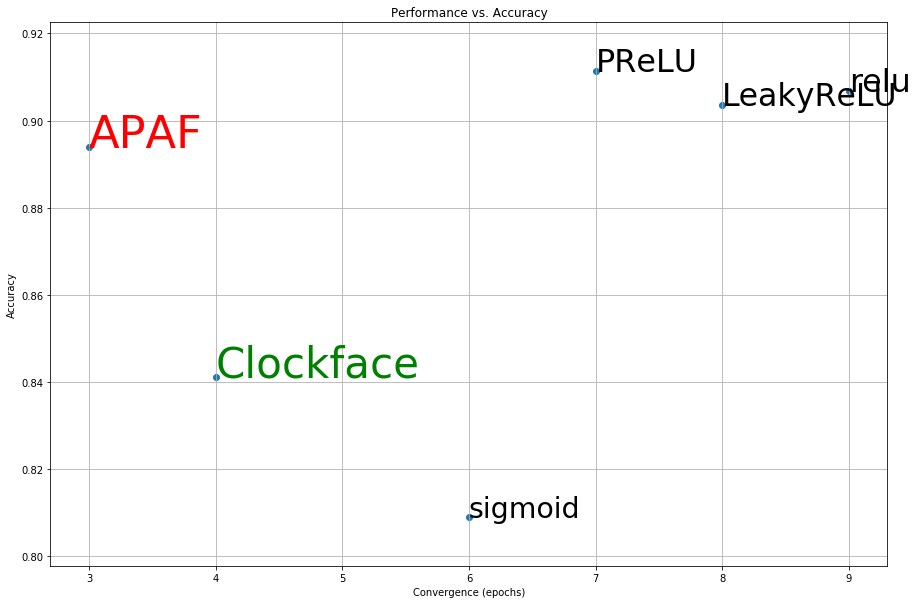

In [0]:
l = res.groupby('Function').agg(np.min)['Epochs']
a = res.groupby('Function').agg(np.max)['Accuracy']

plt.scatter(l,a)
plt.xlabel('Convergence (epochs)')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Performance vs. Accuracy')
for lab in l.index:
  if 'Clockface' in lab:
    plt.text(l[lab],a[lab],lab, size = 50*a[lab], color = 'g')
  elif 'APAF' in lab:
    plt.text(l[lab],a[lab],lab, size = 50*a[lab], color = 'r')
  else:
    plt.text(l[lab],a[lab],lab, size = 35*a[lab])

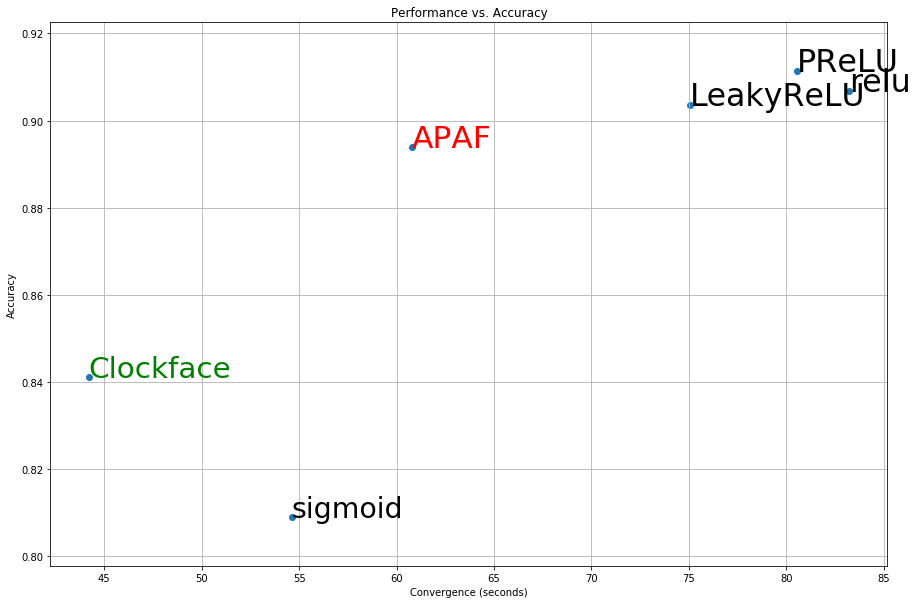

In [0]:
l = res.groupby('Function').agg(np.min)['sTime']
a = res.groupby('Function').agg(np.max)['Accuracy']

plt.scatter(l,a)
plt.xlabel('Convergence (seconds)')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Performance vs. Accuracy')
for lab in l.index:
  if 'Clockface' in lab:
    plt.text(l[lab],a[lab],lab, size = 35*a[lab], color = 'g')
  elif 'APAF' in lab:
    plt.text(l[lab],a[lab],lab, size = 35*a[lab], color = 'r')
  else:
    plt.text(l[lab],a[lab],lab, size = 35*a[lab])

#### Single-layer weights distribution

In [0]:
model = get_model(neurons = 256, layer = layers['Clockface'])
from sklearn import datasets
dots,_ = datasets.make_circles(n_samples = 256, factor = 0.999, noise = 0.01)
model.get_layer('hidden').set_weights(dots.T) # alternative initializtion

In [0]:
%%time
alphas,betas = [],[]
for epoch in range(150):
  rix = random.choices(range(len(x_train)), k = 10000) # train on random part of data for slower convergence
  history = model.fit(x_train[rix], y_train[rix], epochs=1, validation_split=0.25, verbose=0)
  alpha,beta = model.get_layer('hidden').get_weights()
  alphas.append(alpha)
  betas.append(beta)

CPU times: user 5min 11s, sys: 1min 30s, total: 6min 42s
Wall time: 8min 9s


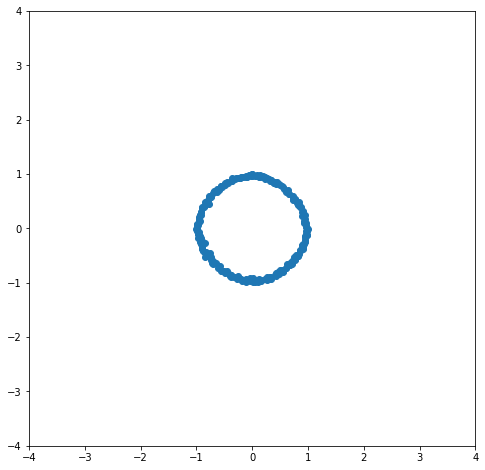

In [0]:
import matplotlib.animation
from IPython.display import HTML

plt.rcParams['animation.embed_limit'] = 50 # animation size limit in megabytes

fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)
# stable data

# animated data
l, = ax.plot([],[], 'o')

def animate(i): # animation function is called on each frame
      l.set_data(betas[i],alphas[i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=range(0,len(alphas),1))

HTML(ani.to_jshtml())

In [0]:
%%time
model = get_model(neurons = 256, layer = acts['Clockface'])

alphas,betas = [],[]
for epoch in range(100):
  rix = random.choices(range(len(x_train)), k = 10000)
  history = model.fit(x_train[rix], y_train[rix], epochs=1, validation_split=0.25, verbose=1)
  alpha,beta = model.get_layer('hidden').get_weights()
  alphas.append(alpha)
  betas.append(beta)

Train on 7500 samples, validate on 2500 samples
7500/7500 [==============================] - 4s 521us/sample - loss: 0.5543 - accuracy: 0.8059 - val_loss: 1.6556 - val_accuracy: 0.5452
Train on 7500 samples, validate on 2500 samples
7500/7500 [==============================] - 3s 449us/sample - loss: 0.4039 - accuracy: 0.8621 - val_loss: 0.8116 - val_accuracy: 0.8216
Train on 7500 samples, validate on 2500 samples
7500/7500 [==============================] - 3s 448us/sample - loss: 0.3502 - accuracy: 0.8800 - val_loss: 0.3628 - val_accuracy: 0.8720
Train on 7500 samples, validate on 2500 samples
7500/7500 [==============================] - 3s 449us/sample - loss: 0.3452 - accuracy: 0.8796 - val_loss: 0.3930 - val_accuracy: 0.8616
Train on 7500 samples, validate on 2500 samples
7500/7500 [==============================] - 3s 447us/sample - loss: 0.3064 - accuracy: 0.8908 - val_loss: 0.3285 - val_accuracy: 0.8804
Train on 7500 samples, validate on 2500 samples
7500/7500 [================

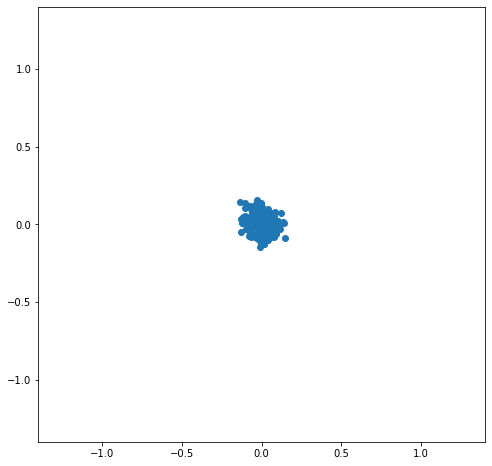

In [0]:
import matplotlib.animation
from IPython.display import HTML

plt.rcParams['animation.embed_limit'] = 50 # animation size limit in megabytes


fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.set_xlim(-1.4,1.4)
ax.set_ylim(-1.4,1.4)
# stable data

# animated data
l, = ax.plot([],[], 'o')

def animate(i): # animation function is called on each frame
      l.set_data(betas[i],alphas[i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=range(0,len(alphas),1))

HTML(ani.to_jshtml())

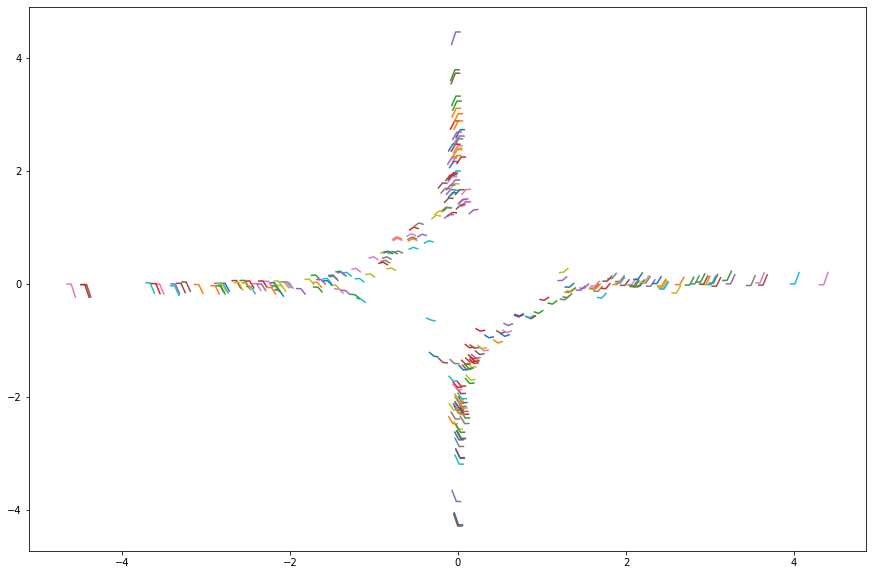

In [0]:

scale = 0.025
frame = 1.
for w in np.array(model.get_layer('hidden').get_weights()).T:
    a,b = w[0],w[1]
    inputs = np.linspace(-2,2)
    pos = a*tf.keras.backend.relu(inputs)
    neg = -b*tf.keras.backend.relu(-inputs)
    output = pos+neg
    plt.plot(a+inputs*scale, b+output*scale)

Train on 45000 samples, validate on 15000 samples
Epoch 1/10
45000/45000 [==============================] - 22s 493us/sample - loss: 0.4030 - accuracy: 0.8609 - val_loss: 0.3504 - val_accuracy: 0.8790
Epoch 2/10
45000/45000 [==============================] - 21s 477us/sample - loss: 0.2690 - accuracy: 0.9041 - val_loss: 0.2925 - val_accuracy: 0.8966
Epoch 3/10
45000/45000 [==============================] - 21s 477us/sample - loss: 0.2199 - accuracy: 0.9211 - val_loss: 0.2798 - val_accuracy: 0.9051
Epoch 4/10
45000/45000 [==============================] - 21s 475us/sample - loss: 0.1895 - accuracy: 0.9308 - val_loss: 0.2899 - val_accuracy: 0.9002
Epoch 5/10
45000/45000 [==============================] - 22s 481us/sample - loss: 0.1679 - accuracy: 0.9395 - val_loss: 0.3193 - val_accuracy: 0.8987
10000/10000 - 1s - loss: 0.3388 - accuracy: 0.8939


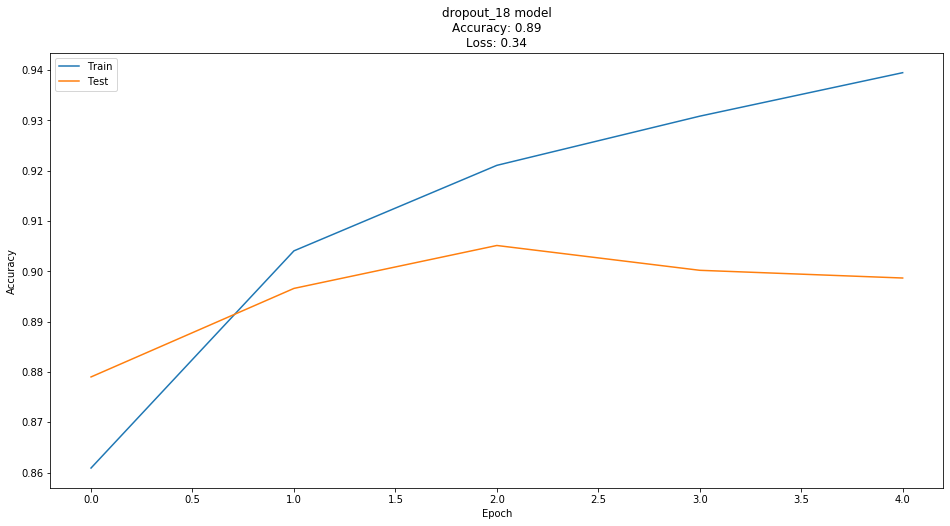

In [0]:
h,model = show_model(get_model(layer = acts['APAF']))

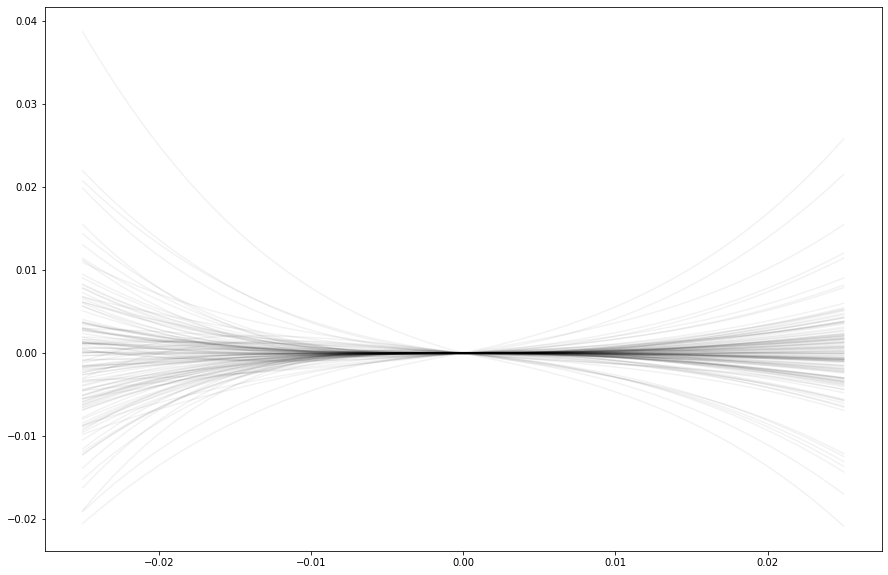

In [0]:

scale = 0.025
frame = 1.
for w in np.array(model.get_layer('hidden').get_weights()).T:
    alpha,beta = w.T[0],w.T[1]
    inputs = np.linspace(-1,1)
    pos = tf.keras.backend.relu(inputs)
    pos = alpha[0] * tf.pow(pos,3) + alpha[1] * tf.pow(pos,2) + alpha[0] * pos
    neg = -tf.keras.backend.relu(-inputs)
    neg = beta[0] * tf.pow(neg,3) + beta[1] * tf.pow(neg,2) + beta[2] * neg
    output = pos+neg
    plt.plot(inputs*scale, output*scale,'k-', alpha = 0.05)

Training Sigmoid
Train on 45000 samples, validate on 15000 samples
Epoch 1/25
45000/45000 [==============================] - 5s 122us/sample - loss: 0.5792 - accuracy: 0.7948 - val_loss: 0.4213 - val_accuracy: 0.8492
Epoch 2/25
45000/45000 [==============================] - 5s 110us/sample - loss: 0.4362 - accuracy: 0.8433 - val_loss: 0.3809 - val_accuracy: 0.8617
Epoch 3/25
45000/45000 [==============================] - 5s 111us/sample - loss: 0.3955 - accuracy: 0.8569 - val_loss: 0.3853 - val_accuracy: 0.8567
Epoch 4/25
45000/45000 [==============================] - 5s 112us/sample - loss: 0.3664 - accuracy: 0.8670 - val_loss: 0.3407 - val_accuracy: 0.8767
Epoch 5/25
45000/45000 [==============================] - 5s 110us/sample - loss: 0.3453 - accuracy: 0.8734 - val_loss: 0.3393 - val_accuracy: 0.8744
Epoch 6/25
45000/45000 [==============================] - 5s 112us/sample - loss: 0.3296 - accuracy: 0.8798 - val_loss: 0.3489 - val_accuracy: 0.8704
Epoch 7/25
45000/45000 [=========

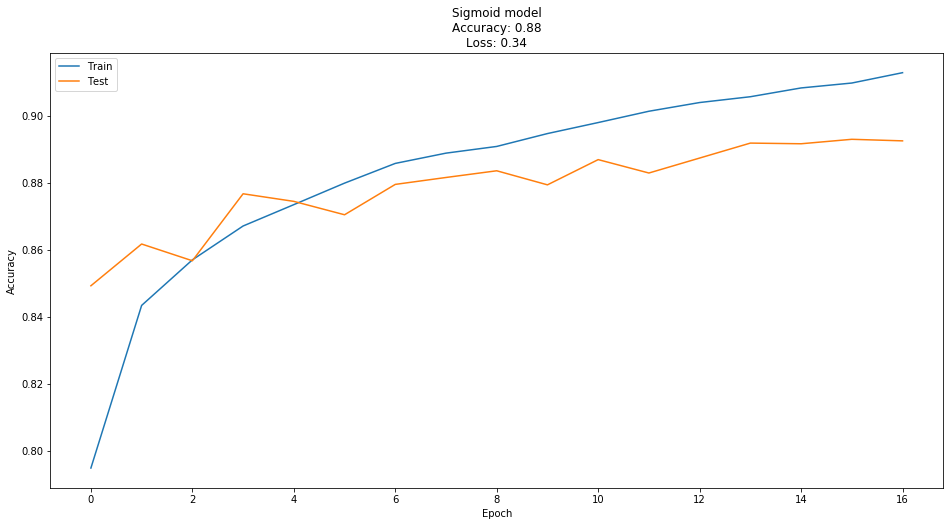

10000/10000 - 1s - loss: 0.3447 - accuracy: 0.8834
Training ReLU
Train on 45000 samples, validate on 15000 samples
Epoch 1/25
45000/45000 [==============================] - 6s 126us/sample - loss: 0.5362 - accuracy: 0.8112 - val_loss: 0.4567 - val_accuracy: 0.8437
Epoch 2/25
45000/45000 [==============================] - 5s 111us/sample - loss: 0.4494 - accuracy: 0.8396 - val_loss: 0.4162 - val_accuracy: 0.8509
Epoch 3/25
45000/45000 [==============================] - 5s 111us/sample - loss: 0.4275 - accuracy: 0.8468 - val_loss: 0.4411 - val_accuracy: 0.8485
Epoch 4/25
45000/45000 [==============================] - 5s 111us/sample - loss: 0.4064 - accuracy: 0.8544 - val_loss: 0.3836 - val_accuracy: 0.8607
Epoch 5/25
45000/45000 [==============================] - 5s 111us/sample - loss: 0.3960 - accuracy: 0.8568 - val_loss: 0.3798 - val_accuracy: 0.8612
Epoch 6/25
45000/45000 [==============================] - 5s 111us/sample - loss: 0.3817 - accuracy: 0.8626 - val_loss: 0.3725 - val_ac

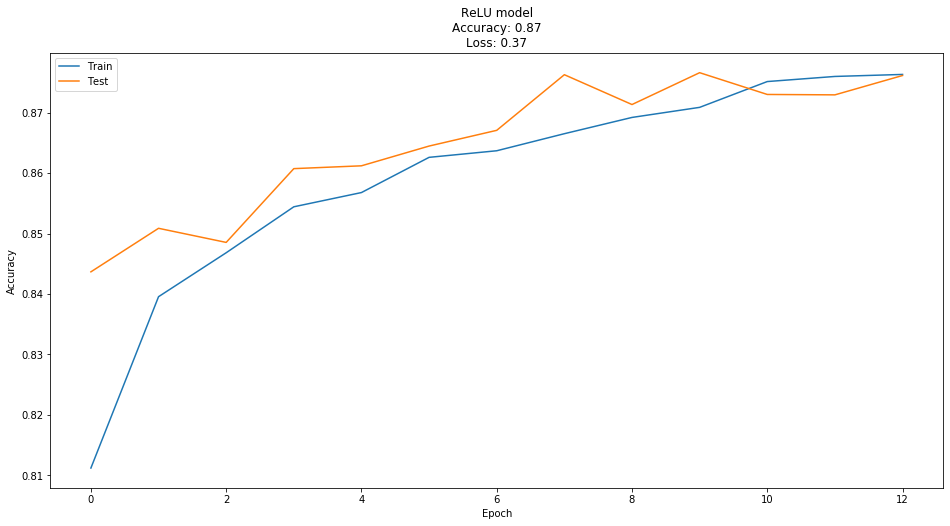

10000/10000 - 1s - loss: 0.3652 - accuracy: 0.8712
Training PReLU
Train on 45000 samples, validate on 15000 samples
Epoch 1/25
45000/45000 [==============================] - 6s 126us/sample - loss: 0.5464 - accuracy: 0.8082 - val_loss: 0.4478 - val_accuracy: 0.8421
Epoch 2/25
45000/45000 [==============================] - 5s 116us/sample - loss: 0.4530 - accuracy: 0.8372 - val_loss: 0.4140 - val_accuracy: 0.8538
Epoch 3/25
45000/45000 [==============================] - 5s 115us/sample - loss: 0.4189 - accuracy: 0.8515 - val_loss: 0.4069 - val_accuracy: 0.8504
Epoch 4/25
45000/45000 [==============================] - 5s 115us/sample - loss: 0.3997 - accuracy: 0.8560 - val_loss: 0.4134 - val_accuracy: 0.8498
Epoch 5/25
45000/45000 [==============================] - 5s 115us/sample - loss: 0.3740 - accuracy: 0.8630 - val_loss: 0.3665 - val_accuracy: 0.8670
Epoch 6/25
45000/45000 [==============================] - 5s 117us/sample - loss: 0.3688 - accuracy: 0.8648 - val_loss: 0.3841 - val_a

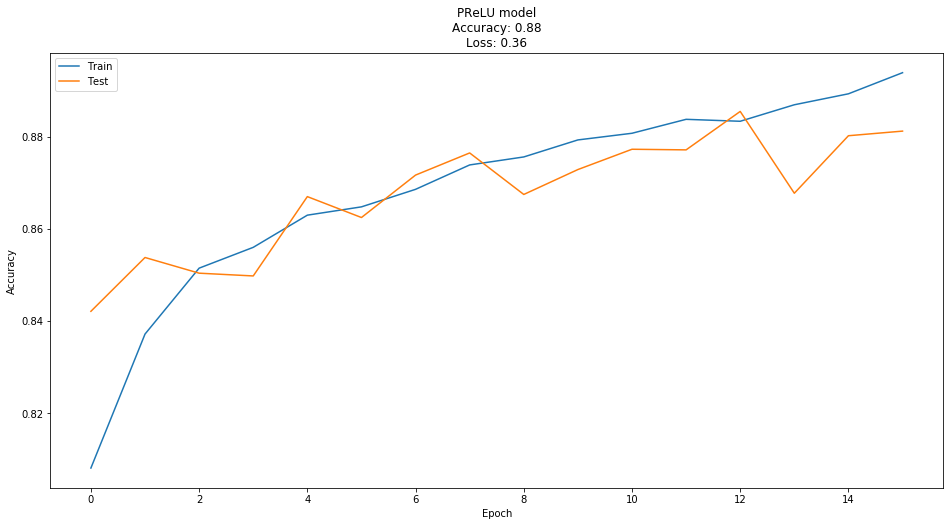

10000/10000 - 1s - loss: 0.3603 - accuracy: 0.8750
Training LeakyReLU
Train on 45000 samples, validate on 15000 samples
Epoch 1/25
45000/45000 [==============================] - 6s 126us/sample - loss: 0.5657 - accuracy: 0.8025 - val_loss: 0.4769 - val_accuracy: 0.8269
Epoch 2/25
45000/45000 [==============================] - 5s 120us/sample - loss: 0.4660 - accuracy: 0.8345 - val_loss: 0.4306 - val_accuracy: 0.8489
Epoch 3/25
45000/45000 [==============================] - 5s 113us/sample - loss: 0.4365 - accuracy: 0.8436 - val_loss: 0.5175 - val_accuracy: 0.8224
Epoch 4/25
45000/45000 [==============================] - 5s 114us/sample - loss: 0.4147 - accuracy: 0.8522 - val_loss: 0.3852 - val_accuracy: 0.8617
Epoch 5/25
45000/45000 [==============================] - 5s 119us/sample - loss: 0.4018 - accuracy: 0.8568 - val_loss: 0.3876 - val_accuracy: 0.8627
Epoch 6/25
45000/45000 [==============================] - 5s 117us/sample - loss: 0.3893 - accuracy: 0.8599 - val_loss: 0.3647 - v

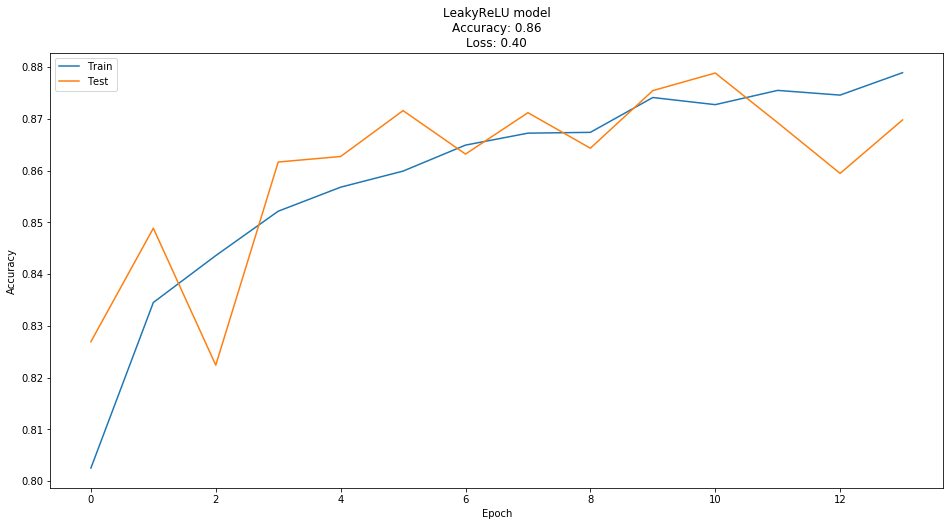

10000/10000 - 1s - loss: 0.3956 - accuracy: 0.8576
Training Clockface
Train on 45000 samples, validate on 15000 samples
Epoch 1/25
45000/45000 [==============================] - 6s 130us/sample - loss: 0.5459 - accuracy: 0.8112 - val_loss: 0.4701 - val_accuracy: 0.8285
Epoch 2/25
45000/45000 [==============================] - 5s 117us/sample - loss: 0.4394 - accuracy: 0.8429 - val_loss: 0.3883 - val_accuracy: 0.8617
Epoch 3/25
45000/45000 [==============================] - 5s 118us/sample - loss: 0.4036 - accuracy: 0.8543 - val_loss: 0.3703 - val_accuracy: 0.8696
Epoch 4/25
45000/45000 [==============================] - 5s 117us/sample - loss: 0.3801 - accuracy: 0.8617 - val_loss: 0.3601 - val_accuracy: 0.8705
Epoch 5/25
45000/45000 [==============================] - 5s 117us/sample - loss: 0.3630 - accuracy: 0.8688 - val_loss: 0.3836 - val_accuracy: 0.8619
Epoch 6/25
45000/45000 [==============================] - 5s 117us/sample - loss: 0.3516 - accuracy: 0.8717 - val_loss: 0.3395 - v

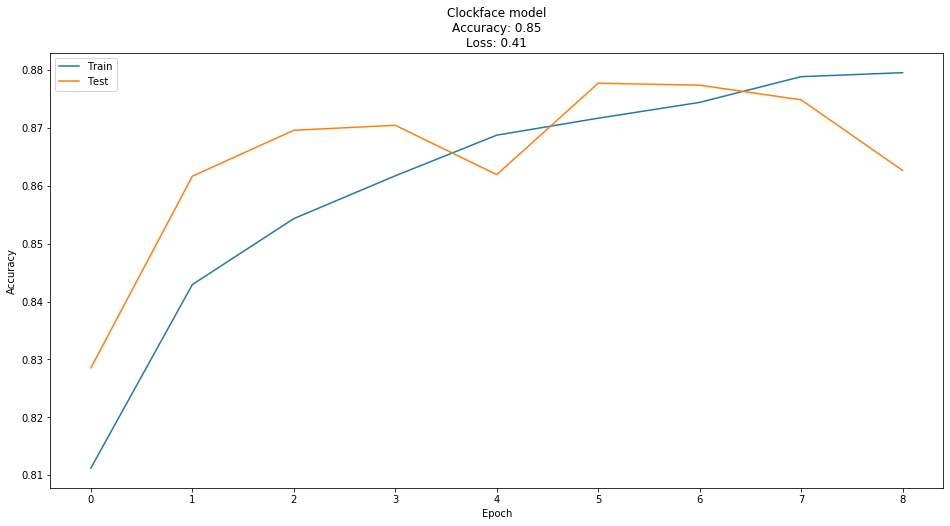

10000/10000 - 1s - loss: 0.4058 - accuracy: 0.8547
Training APAF
Train on 45000 samples, validate on 15000 samples
Epoch 1/25
45000/45000 [==============================] - 7s 145us/sample - loss: 0.5778 - accuracy: 0.8047 - val_loss: 0.5939 - val_accuracy: 0.8016
Epoch 2/25
45000/45000 [==============================] - 6s 129us/sample - loss: 0.4752 - accuracy: 0.8370 - val_loss: 0.5056 - val_accuracy: 0.8299
Epoch 3/25
45000/45000 [==============================] - 6s 128us/sample - loss: 0.4450 - accuracy: 0.8448 - val_loss: 0.6927 - val_accuracy: 0.8030
Epoch 4/25
45000/45000 [==============================] - 6s 126us/sample - loss: 0.4251 - accuracy: 0.8512 - val_loss: 0.4555 - val_accuracy: 0.8490
Epoch 5/25
45000/45000 [==============================] - 6s 129us/sample - loss: 0.4083 - accuracy: 0.8561 - val_loss: 0.4619 - val_accuracy: 0.8542
Epoch 6/25
45000/45000 [==============================] - 6s 133us/sample - loss: 0.3926 - accuracy: 0.8599 - val_loss: 0.4676 - val_ac

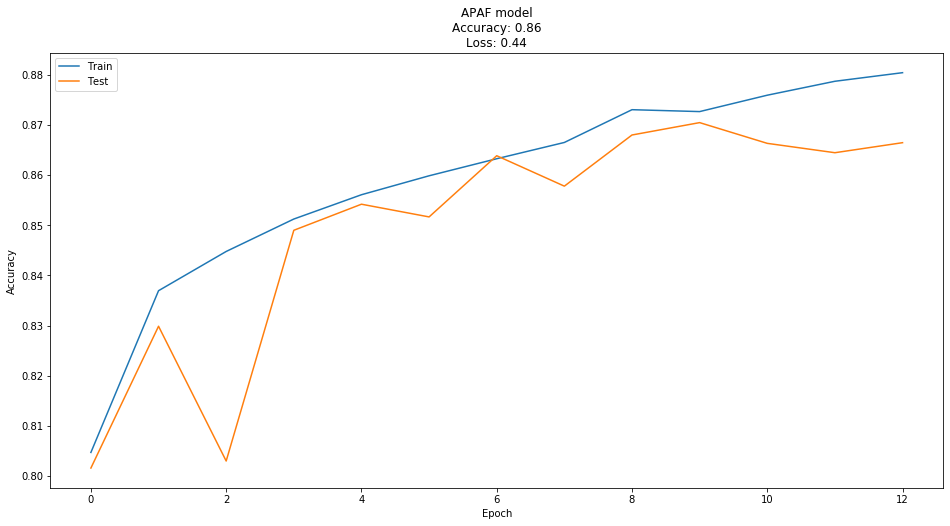

10000/10000 - 1s - loss: 0.4399 - accuracy: 0.8575
CPU times: user 9min 36s, sys: 44.9 s, total: 10min 21s
Wall time: 7min 22s


In [0]:
%%time
models = {}
results = {}
hst = {}
for layer in layers:
    print('Training', layer)
    hst[layer],models[layer] = show_model(get_model(layer = layer), neurons, epochs)
    loss, acc = models[layer].evaluate(x_test,  y_test, verbose=2)
    results[layer] = {'Loss':loss,'Accuracy':acc}

In [0]:
models

{'APAF': <tensorflow.python.keras.engine.sequential.Sequential at 0x7efe2a986908>,
 'Clockface': <tensorflow.python.keras.engine.sequential.Sequential at 0x7efe1034c978>,
 'LeakyReLU': <tensorflow.python.keras.engine.sequential.Sequential at 0x7efe2ac5bd68>,
 'PReLU': <tensorflow.python.keras.engine.sequential.Sequential at 0x7efde6fc05f8>,
 'ReLU': <tensorflow.python.keras.engine.sequential.Sequential at 0x7efe101c57f0>,
 'Sigmoid': <tensorflow.python.keras.engine.sequential.Sequential at 0x7efea1bd0fd0>}

In [0]:
{m:len(h['time']) for m,h in hst.items()}

{'APAF': 6,
 'Clockface': 6,
 'LeakyReLU': 10,
 'PReLU': 6,
 'ReLU': 6,
 'Sigmoid': 25}

In [0]:
results

{'APAF': {'Accuracy': 0.8929, 'Loss': 0.35212900468111036},
 'Clockface': {'Accuracy': 0.8882, 'Loss': 0.36838828308582305},
 'LeakyReLU': {'Accuracy': 0.8693, 'Loss': 0.3788727907180786},
 'PReLU': {'Accuracy': 0.8766, 'Loss': 0.42671710334420204},
 'ReLU': {'Accuracy': 0.8841, 'Loss': 0.410119791162014},
 'Sigmoid': {'Accuracy': 0.8782, 'Loss': 0.36266313658952715}}

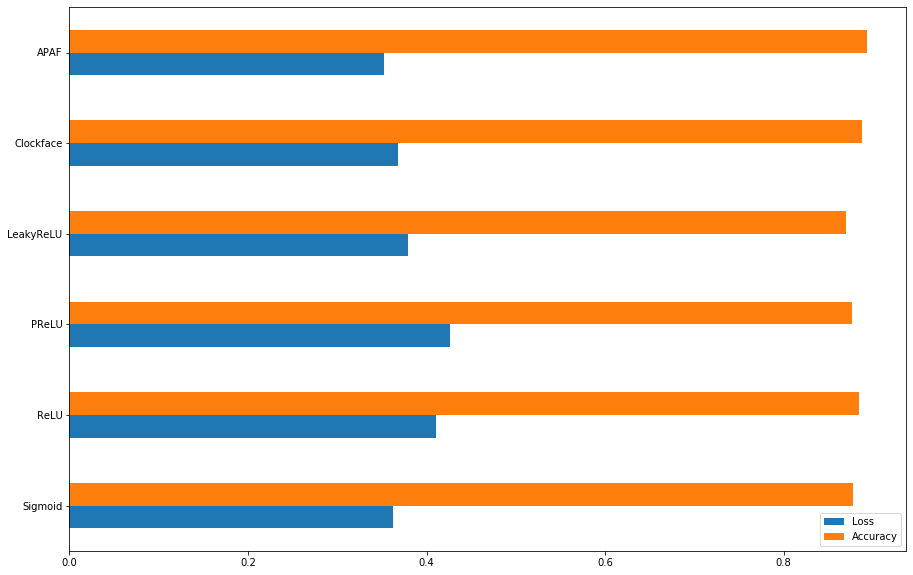

In [0]:
pd.DataFrame(results).T.plot(kind = 'barh')

In [0]:
for model in models:
    print(model, np.array(models[model].get_layer(model).get_weights()).shape)

Sigmoid (0,)
ReLU (0,)
PReLU (1, 28, 28, 256)
LeakyReLU (0,)
Clockface (2, 256)
APAF (2, 3, 256)


# Plots

In [0]:
np.shape(models['PReLU'].get_layer('PReLU').get_weights())

(1, 28, 28, 256)

ValueError: ignored

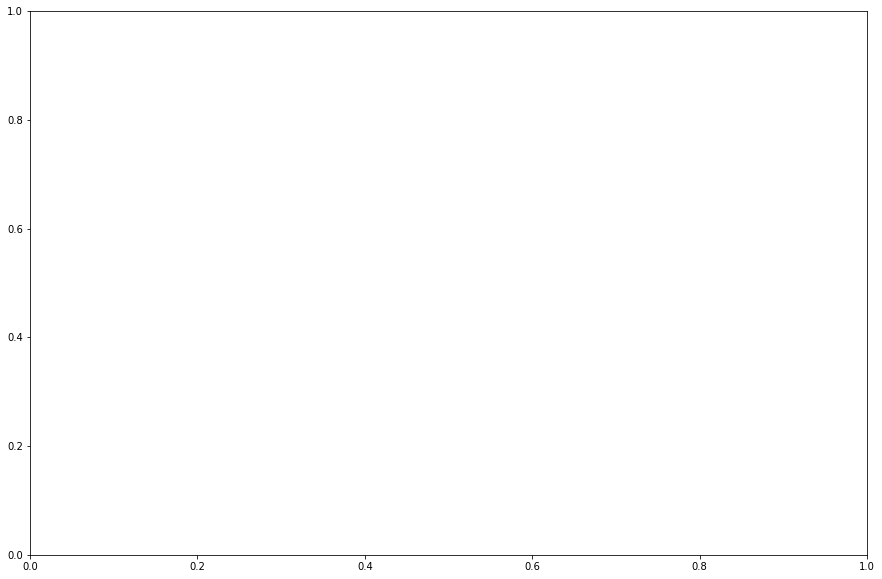

In [0]:
beta = models['PReLU'].get_layer('PReLU').get_weights()[0]
plt.hist(beta, bins = 50)

In [0]:
alpha = models['PReLU'].get_layer(index = 1).get_weights()[1]

In [0]:
plt.plot(alpha,beta,'o')

In [0]:
inputs = np.linspace(-1,1)
scale = 0.025
frame = 1.
for a,b in zip(alpha,beta):
    pos = a*tf.keras.backend.relu(inputs)
    neg = -b*tf.keras.backend.relu(-inputs)
    output = pos+neg
    plt.plot(a+inputs*scale, -b+output*scale)
plt.xlim((-frame,frame))
plt.ylim((-frame,frame))

In [0]:
scale = 0.025
frame = 2
x = np.linspace(-frame, frame, 50)
y = np.linspace(-frame, frame, 50)
X, Y = np.meshgrid(x, y)
grid = np.c_[X.flatten(),Y.flatten()]
for a,b in grid:
    pos = a*tf.keras.backend.relu(inputs)
    neg = -b*tf.keras.backend.relu(-inputs)
    output = pos+neg
    plt.plot(a+inputs*scale, -b+output*scale, color = 'k')
plt.xlim((-frame,frame))
plt.ylim((-frame,frame))

plt.plot(alpha,beta,'o')

## Clockface

In [0]:
s = model.get_layer('hidden')
alpha,beta = s.get_weights()

In [0]:
pd.DataFrame(s.get_weights()).T.style.background_gradient()

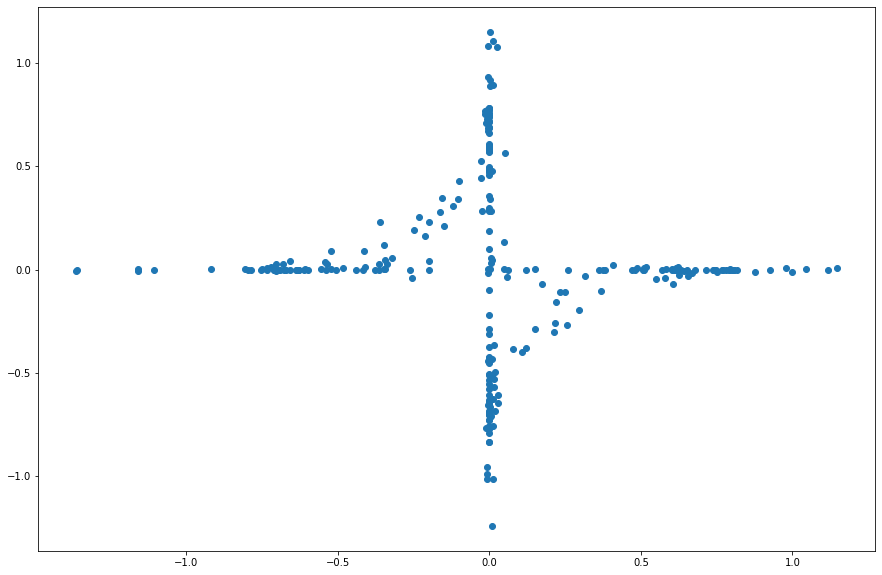

In [0]:
alpha,beta = s.get_weights()
plt.plot(alpha,beta,'o')

(-1.0, 1.0)

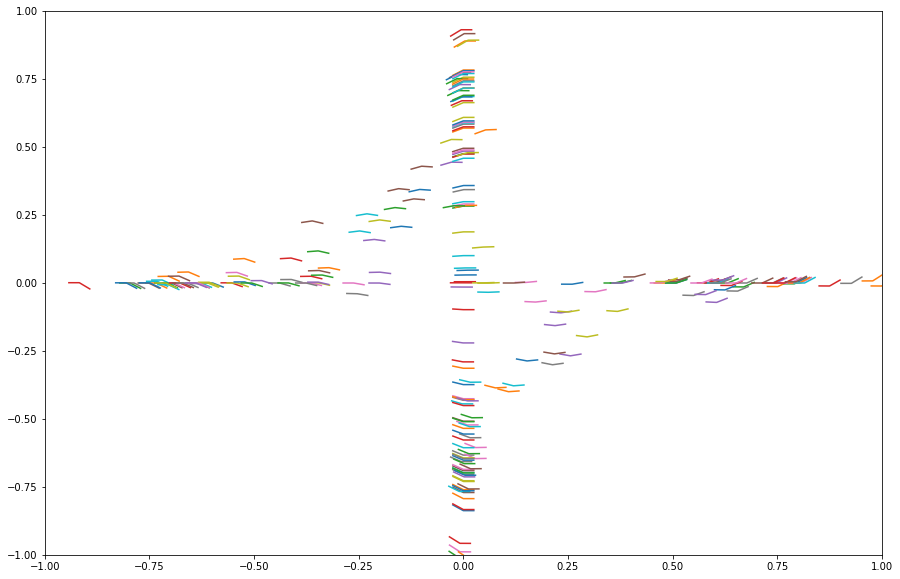

In [0]:
inputs = np.linspace(-1,1)
scale = 0.025
frame = 1.
for a,b in zip(alpha,beta):
    pos = a*tf.keras.backend.relu(inputs)
    neg = -b*tf.keras.backend.relu(-inputs)
    output = pos+neg
    plt.plot(a+inputs*scale, b+output*scale)
plt.xlim((-frame,frame))
plt.ylim((-frame,frame))
    

In [0]:
plt.text(a, b, s = str(a/b))

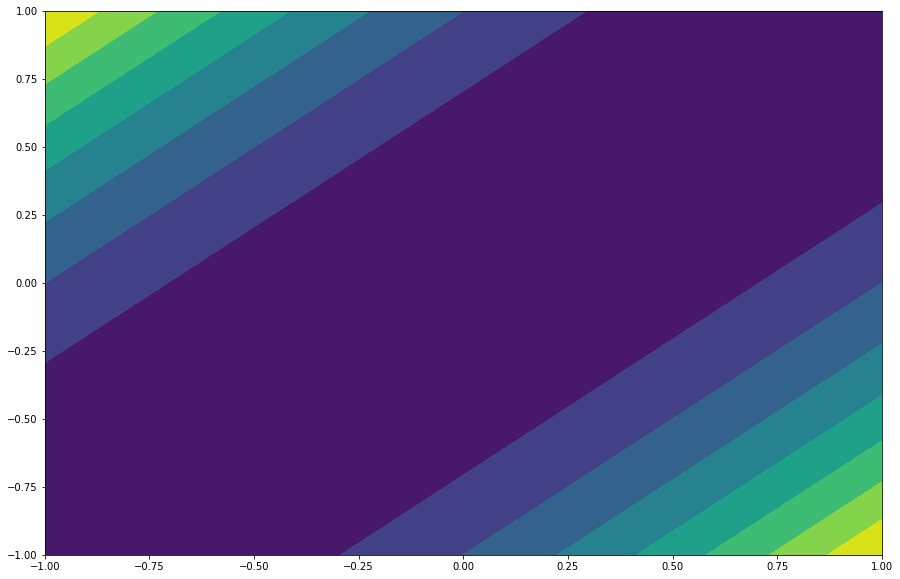

In [0]:
x = np.linspace(-frame, frame, 100)
y = np.linspace(-frame, frame, 100)
X, Y = np.meshgrid(x, y)
plt.contourf(X,Y,X*X+Y*Y-2*X*Y) # it should indicate where weights are linear

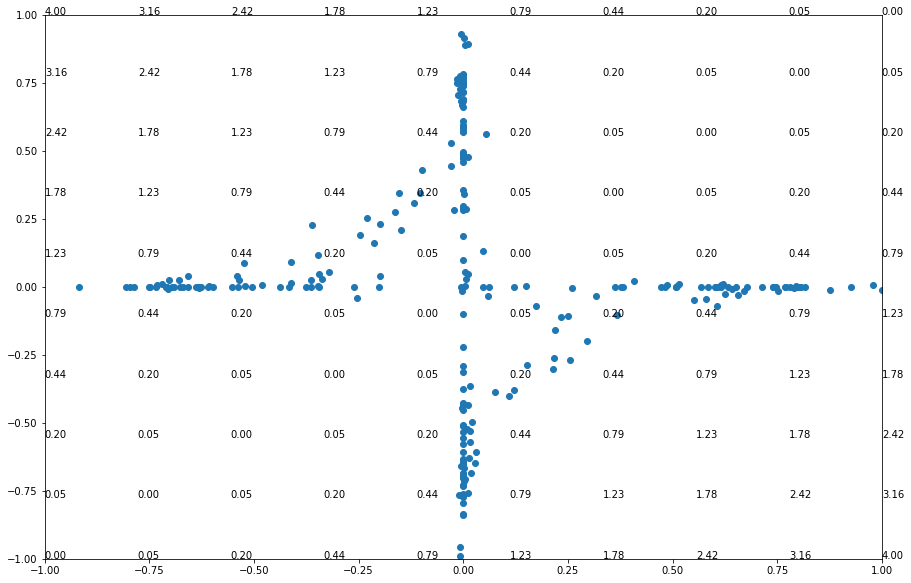

In [0]:
scale = 0.025
frame = 1
x = np.linspace(-frame, frame, 10)
y = np.linspace(-frame, frame, 10)
X, Y = np.meshgrid(x, y)
grid = np.c_[X.flatten(),Y.flatten()]
for a,b in grid:
    pos = a*tf.keras.backend.relu(inputs)
    neg = -b*tf.keras.backend.relu(-inputs)
    output = pos+neg
    plt.text(a, b, s = '%.2f'%(a*a+b*b-2*a*b))
    #plt.plot(a+inputs*scale, b+output*scale, color = 'k')
plt.xlim((-frame,frame))
plt.ylim((-frame,frame))
plt.plot(alpha,beta,'o')

(-1, 1)

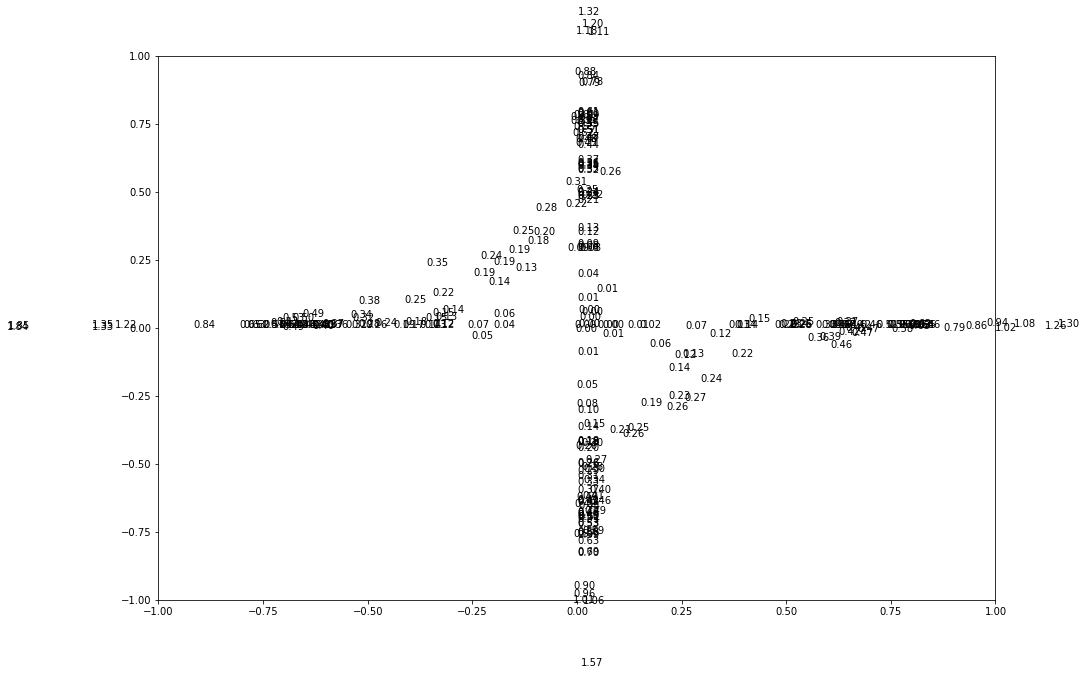

In [0]:
for a,b in zip(alpha,beta):
    plt.text(a, b, s = '%.2f'%(a*a+b*b-2*a*b))
plt.xlim((-frame,frame))
plt.ylim((-frame,frame))

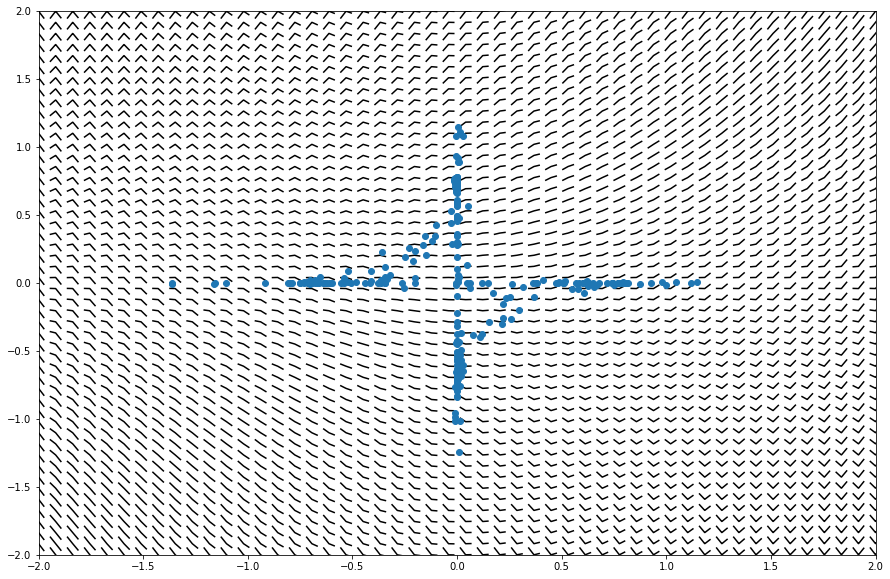

In [0]:
scale = 0.025
frame = 2
x = np.linspace(-frame, frame, 50)
y = np.linspace(-frame, frame, 50)
X, Y = np.meshgrid(x, y)
grid = np.c_[X.flatten(),Y.flatten()]
for a,b in grid:
    pos = a*tf.keras.backend.relu(inputs)
    neg = -b*tf.keras.backend.relu(-inputs)
    output = pos+neg
    plt.plot(a+inputs*scale, b+output*scale, color = 'k')
plt.xlim((-frame,frame))
plt.ylim((-frame,frame))

plt.plot(alpha,beta,'o')

In [0]:
weights = model.get_layer(index = 1).get_weights()[1]

In [0]:
weights = models['Clockface'].get_layer(index = 1).get_weights()[1]

In [0]:
df = pd.DataFrame()
df['alpha'] = alpha
df['beta'] = beta
df['ang'] = alpha**2 + beta**2 - 2*alpha*beta
df.style.background_gradient()

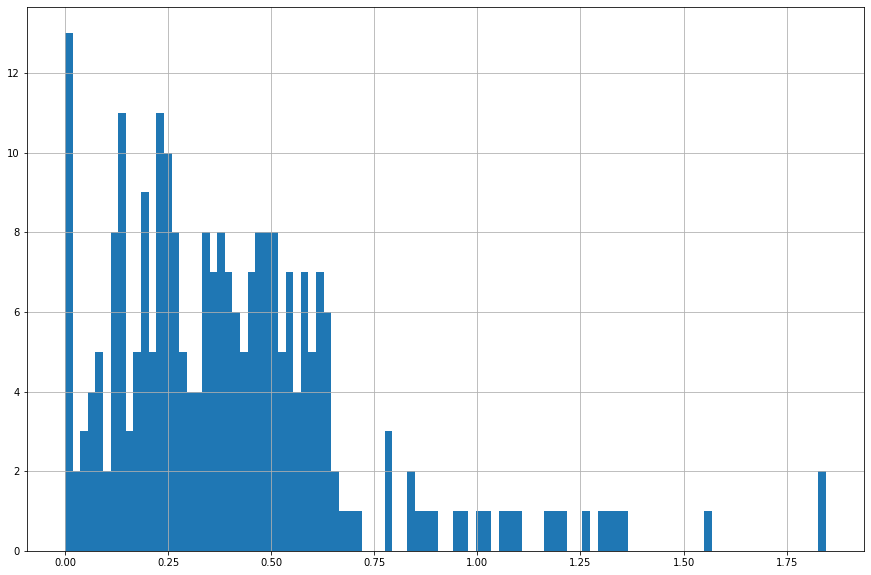

In [0]:
df['ang'].hist(bins = 100)

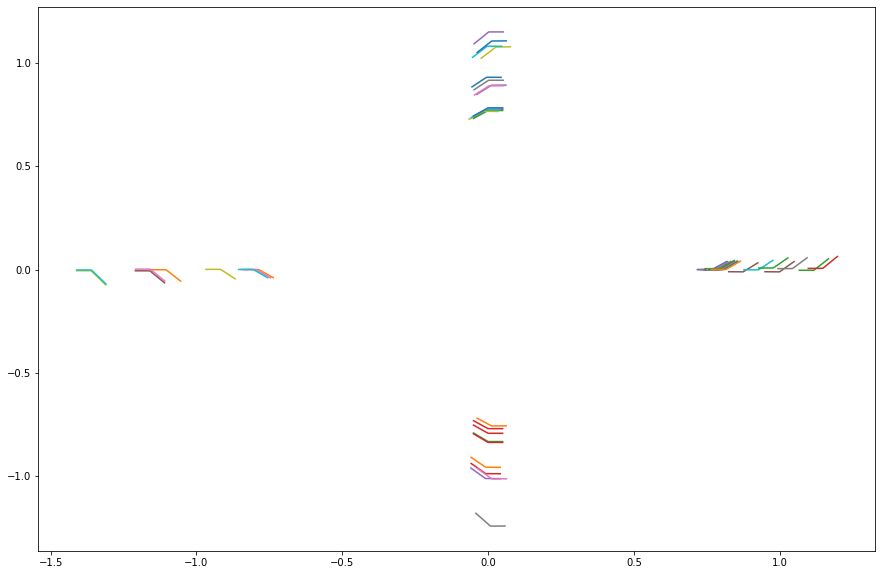

In [0]:
for w in df.sort_values('ang').tail(50).values:
    a,b = w[0],w[1]
    inputs = np.linspace(-2,2)
    pos = a*tf.keras.backend.relu(inputs)
    neg = -b*tf.keras.backend.relu(-inputs)
    output = pos+neg
    plt.plot(a+inputs*scale, b+output*scale)

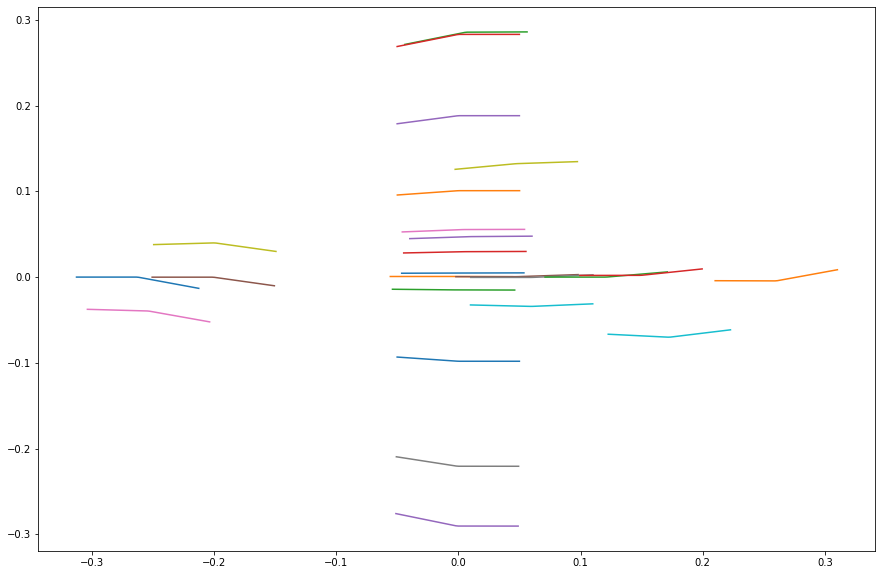

In [0]:
for w in df.sort_values('ang').head(25).values:
    a,b = w[0],w[1]
    inputs = np.linspace(-2,2)
    pos = a*tf.keras.backend.relu(inputs)
    neg = -b*tf.keras.backend.relu(-inputs)
    output = pos+neg
    plt.plot(a+inputs*scale, b+output*scale)

### Distillation

In [0]:
lins_ix = df.sort_values('ang').index #linear neurons
orig_w = model.get_layer('hidden').get_weights()

In [0]:
model.evaluate(x_test,  y_test, verbose=2)[1]

10000/10000 - 1s - loss: 0.5423 - accuracy: 0.8988


0.8988

In [0]:
%%time
raccs = []
ones = np.ones_like(orig_w)
for i in lins_ix[::-1]: # nullify starting from most non-linear neurons
  ones[0].T[i]  *= 0
  ones[1].T[i] *= 0
  #ones[0][i-1],ones[1][i-1] = 0,0
  #ones[0][i-2],ones[1][i-2] = 0,0
  
  model.get_layer('hidden').set_weights(orig_w*ones)
  raccs.append(model.evaluate(x_test,  y_test, verbose=0)[1])

CPU times: user 4min 25s, sys: 28.5 s, total: 4min 53s
Wall time: 5min 55s


In [0]:
model.get_layer('hidden').set_weights(orig_w)
model.evaluate(x_test,  y_test, verbose=2)[1]

10000/10000 - 1s - loss: 0.5423 - accuracy: 0.8988


0.8988

In [0]:
%%time
accs = []
ones = np.ones_like(orig_w)
for i in lins_ix: # nullify starting from most linear neurons
  ones[0].T[i]  *= 0
  ones[1].T[i] *= 0
  #ones[0][i-1],ones[1][i-1] = 0,0
  #ones[0][i-2],ones[1][i-2] = 0,0
  
  model.get_layer('hidden').set_weights(orig_w*ones)
  accs.append(model.evaluate(x_test,  y_test, verbose=0)[1])

CPU times: user 4min 23s, sys: 27.3 s, total: 4min 50s
Wall time: 5min 54s


In [0]:
model.get_layer('hidden').set_weights(orig_w)
model.evaluate(x_test,  y_test, verbose=2)[1]

10000/10000 - 1s - loss: 0.5423 - accuracy: 0.8988


0.8988

Text(0.5, 1.0, 'Distilling')

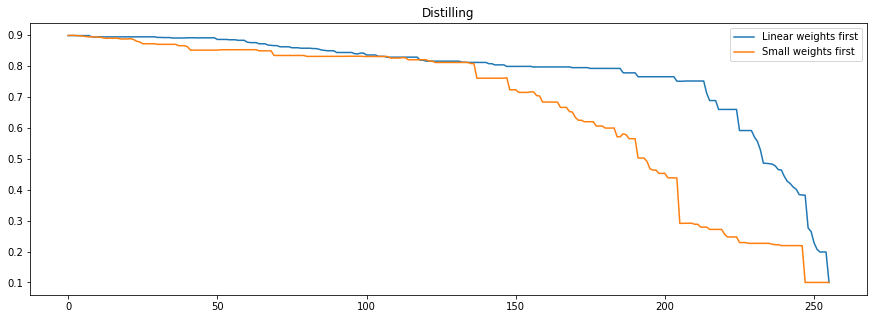

In [0]:
plt.figure(figsize = (15,5))
plt.plot(accs, label = 'Linear weights first')
plt.plot(raccs, label = 'Small weights first')
plt.legend()
plt.title('Distilling')

In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'resnet.txt'})
#uploaded2 = drive.CreateFile({'title': 'hist.txt'})


#### Size test

In [0]:
neurons = [64,128,256,512,1024]

In [0]:
%%time
res = {}
for neuron in neurons:
    ''' Check if different networks sizes converges to similar size '''
    h,model = show_model('Clockface', neuron, 50, silent = True)
    orig_w = alpha,beta = model.get_layer('Clockface').get_weights()
    df = pd.DataFrame()
    df['alpha'] = alpha
    df['beta'] = beta
    df['ang'] = alpha**2 + beta**2 - 2*alpha*beta

    lins_ix = df.sort_values('ang').index
    accs = []
    ones = np.ones_like(orig_w)
    for n,i in enumerate(lins_ix):
        ones[0].T[i]  *= 0
        ones[1].T[i] *= 0
        #ones[0][i-1],ones[1][i-1] = 0,0
        #ones[0][i-2],ones[1][i-2] = 0,0
        
        model.get_layer('Clockface').set_weights(orig_w*ones)
        accs.append(model.evaluate(x_test,  y_test, verbose=0)[1])

        if accs[0]-accs[-1] > 0.05:
            model.get_layer('Clockface').set_weights(orig_w)
            print(neuron, n)
            res[neuron] = {'N':n, 'Left':neuron-n, 'Acc':accs[-1]}
            uploaded.SetContentString(str(res))
            uploaded.Upload()
            break

Train on 45000 samples, validate on 15000 samples
Epoch 1/50
45000/45000 [==============================] - 9s 197us/sample - loss: 0.4004 - accuracy: 0.8606 - val_loss: 0.3009 - val_accuracy: 0.8935
Epoch 2/50
45000/45000 [==============================] - 8s 186us/sample - loss: 0.2786 - accuracy: 0.9010 - val_loss: 0.2968 - val_accuracy: 0.8939
Epoch 3/50
45000/45000 [==============================] - 9s 192us/sample - loss: 0.2337 - accuracy: 0.9156 - val_loss: 0.2949 - val_accuracy: 0.8939
Epoch 4/50
45000/45000 [==============================] - 9s 192us/sample - loss: 0.2049 - accuracy: 0.9252 - val_loss: 0.3005 - val_accuracy: 0.8987
Epoch 5/50
45000/45000 [==============================] - 8s 185us/sample - loss: 0.1871 - accuracy: 0.9309 - val_loss: 0.3079 - val_accuracy: 0.8965
Epoch 6/50
45000/45000 [==============================] - 8s 187us/sample - loss: 0.1695 - accuracy: 0.9383 - val_loss: 0.3173 - val_accuracy: 0.8991
10000/10000 - 1s - loss: 0.3333 - accuracy: 0.8926

InvalidConfigError: ignored

In [15]:
res = {64: {'N': 45, 'Left': 19, 'Acc': 0.8406}, 128: {'N': 94, 'Left': 34, 'Acc': 0.836}, 256: {'N': 227, 'Left': 29, 'Acc': 0.8206}, 512: {'N': 488, 'Left': 24, 'Acc': 0.8405}, 1024: {'N':981, 'Left':1024-981,'Acc':0.8879}}
res

{64: {'Acc': 0.8406, 'Left': 19, 'N': 45},
 128: {'Acc': 0.836, 'Left': 34, 'N': 94},
 256: {'Acc': 0.8206, 'Left': 29, 'N': 227},
 512: {'Acc': 0.8405, 'Left': 24, 'N': 488},
 1024: {'Acc': 0.8879, 'Left': 43, 'N': 981}}

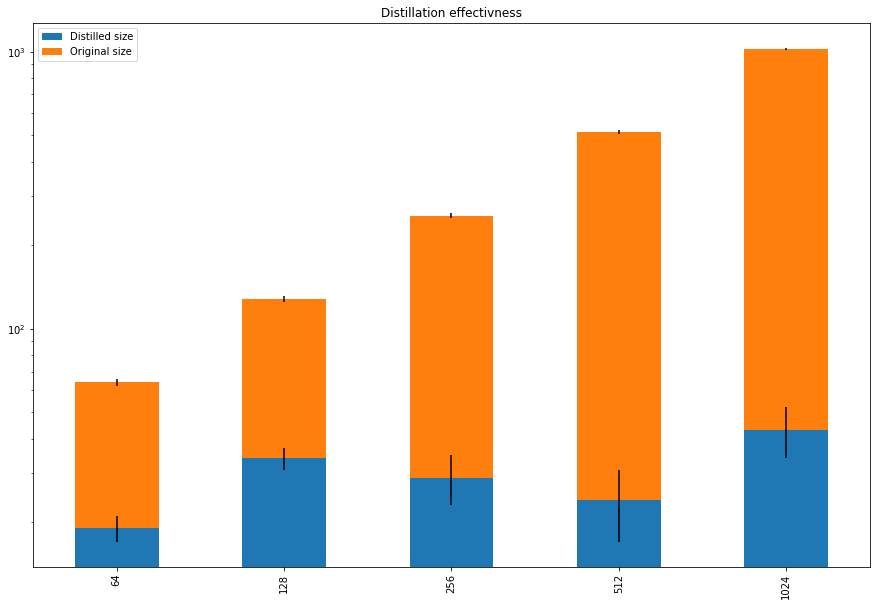

In [16]:
d = pd.DataFrame(res)[:2][::-1].T
d.columns = ['Original size', 'Distilled size'][::-1]
d.plot(kind = 'bar',logy = True,yerr = [2,3,6,7,9], stacked = True, title = 'Distillation effectivness')

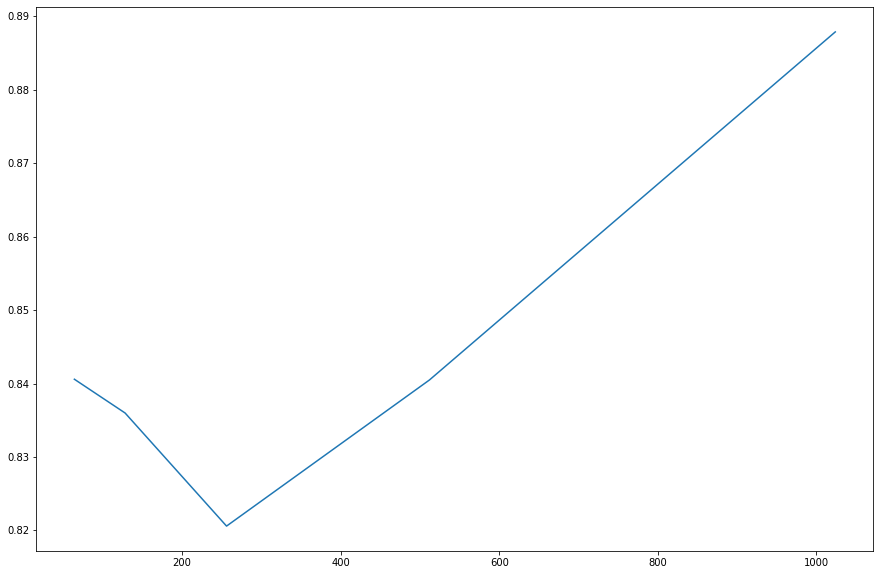

In [25]:
plt.plot([k for k in res.keys()],[res[k]['Acc'] for k in res.keys()])
#plt.plot([res[k]['Left'] for k in res.keys()],[res[k]['Acc'] for k in res.keys()])

## AdaPAF

In [0]:
s = models['APAF'].get_layer('APAF')
alpha,beta = s.get_weights()
w = {i:(a,b) for i,(a,b) in enumerate(zip(alpha.T,beta.T))}

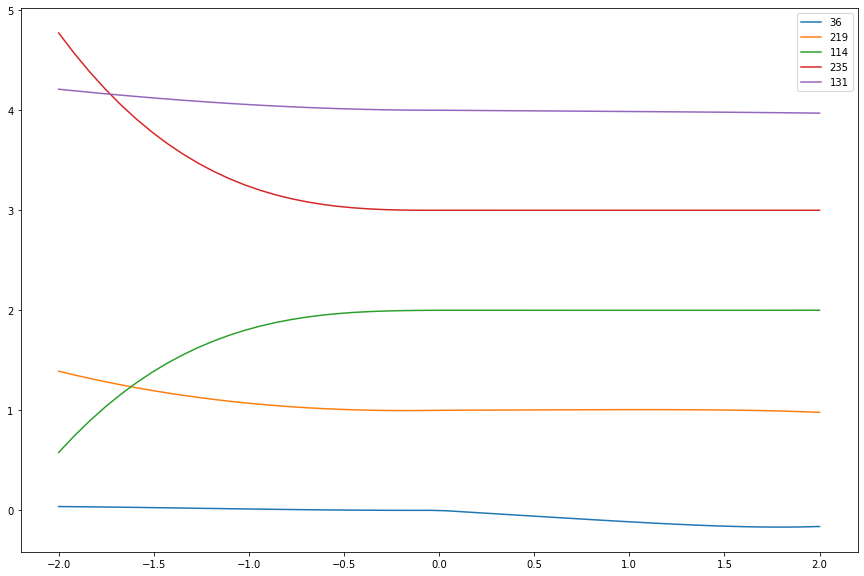

In [0]:
ix = random.choices(list(w.keys()), k = 5)
for n,i in enumerate(ix):
  a,b = w[i]
  inputs = np.linspace(-2,2)
  pos = tf.keras.backend.relu(inputs)
  pos = a[0] * tf.pow(pos,3) * a[1] * tf.pow(pos,2) + a[0] * pos
  neg = tf.keras.backend.relu(-inputs)
  neg = -b[0] * tf.pow(neg,3) -b[1] * tf.pow(neg,2) -b[2] * neg
  output = n+pos+neg
  plt.plot(inputs, output, label = i)
plt.legend()

In [0]:
sums = np.array([(sum(a),sum(b)) for (a,b) in w.values()])

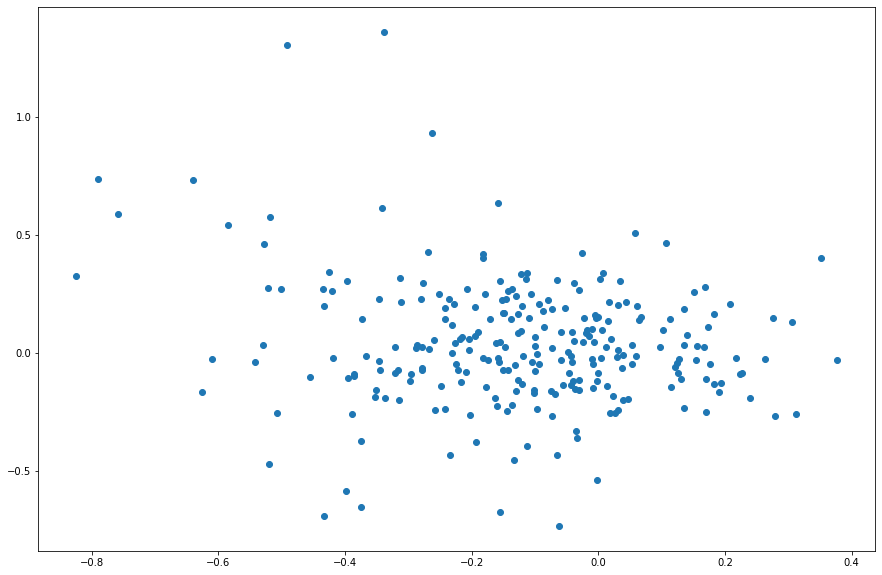

In [0]:
plt.plot(sums.T[0], sums.T[1], 'o')

In [0]:
r = np.array(np.linspace(-1,1))
scale = 0.025
frame = 1.
for a,b in list(w.values()):
  inputs = np.linspace(-2,2)
  pos = tf.keras.backend.relu(inputs)
  pos = a[0] * tf.pow(pos,3) + a[1] * tf.pow(pos,2) + a[0] * pos
  neg = tf.keras.backend.relu(-inputs)
  neg = -b[0] * tf.pow(neg,3) -b[1] * tf.pow(neg,2) -b[2] * neg
  output = pos+neg
  plt.plot(sum(a) + inputs*scale, -sum(b) + output*scale)
plt.xlim((-frame,frame))
plt.ylim((-frame,frame))

AttributeError: ignored

In [0]:
df = pd.DataFrame(np.r_[alpha,beta]).T
df['Diff'] = df.iloc[:,:3].sum(axis = 1) - df.iloc[:,3:].sum(axis = 1)

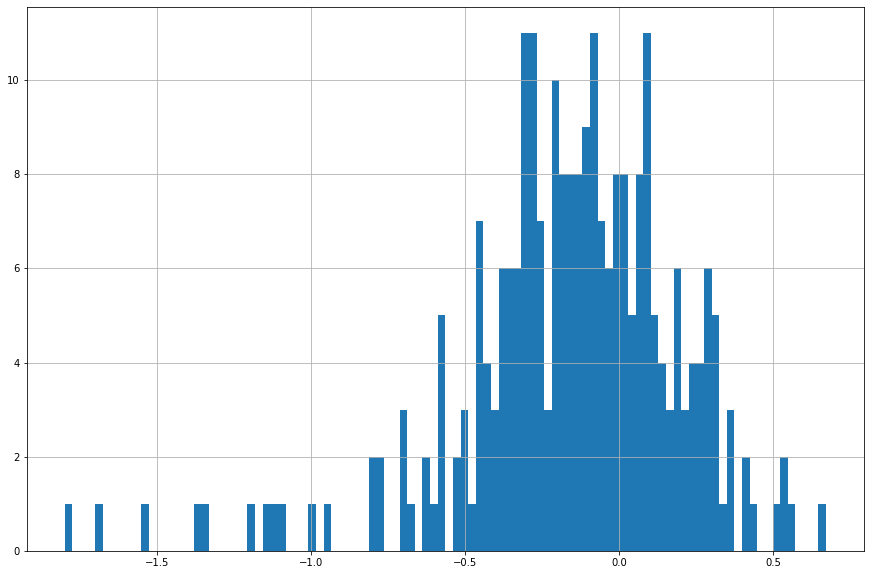

In [0]:
df.Diff.hist(bins = 100)

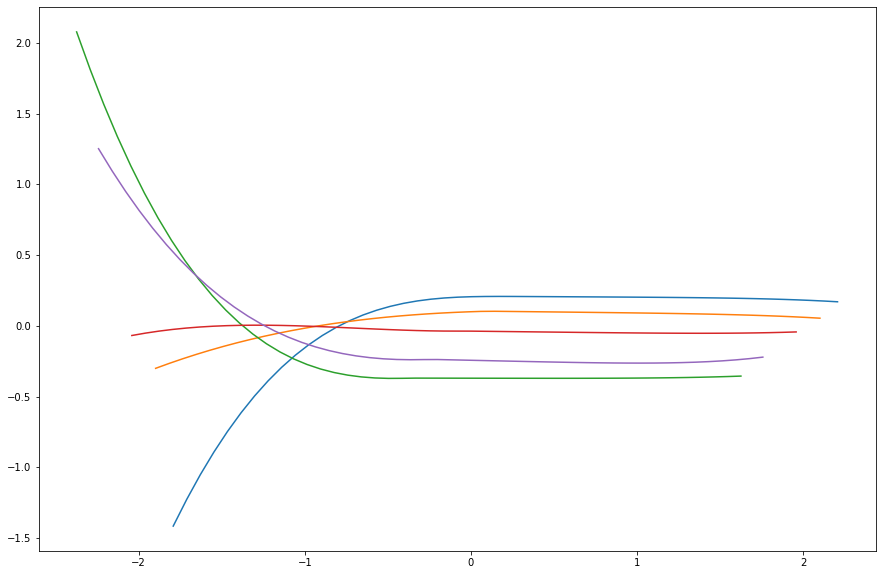

In [0]:
df['abs_diff'] = df.Diff.abs()
for w in df.sort_values('abs_diff').head().values:
    a,b = w[:3],w[3:]
    inputs = np.linspace(-2,2)
    pos = tf.keras.backend.relu(inputs)
    pos = a[0] * tf.pow(pos,3) * a[1] * tf.pow(pos,2) + a[0] * pos
    neg = tf.keras.backend.relu(-inputs)
    neg = -b[0] * tf.pow(neg,3) -b[1] * tf.pow(neg,2) -b[2] * neg
    output = pos+neg
    plt.plot(sum(a)+inputs, sum(b)+output, label = i)

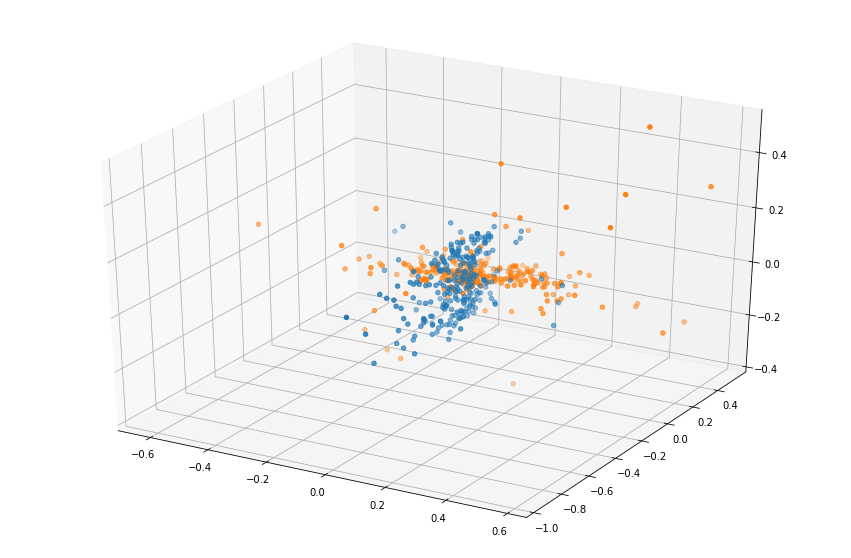

In [0]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(alpha[0], alpha[1], alpha[2]);
ax.scatter3D(beta[0], beta[1], beta[2])

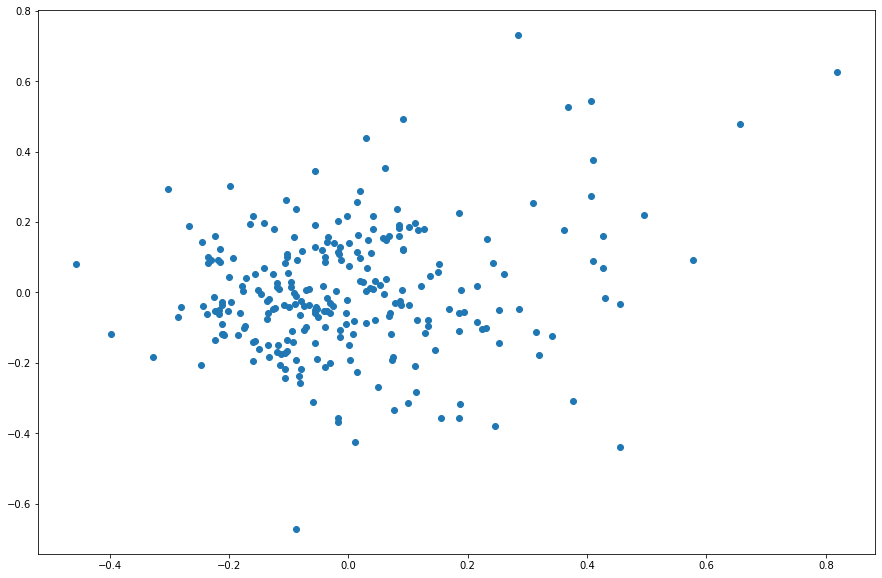

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
A = alpha.T#np.r_[alpha.T,beta.T]
X_a = pca.fit(A).transform(A)
B = beta.T
X_b = pca.fit(B).transform(B)
X_a.T[0]
plt.plot(X_a.T[0],X_b.T[0], 'o')

# Statistics

In [0]:
%%time
iters = 10
models = {}
val = {}
hst = {}
for layer in layers:
    for i in range(iters):
        print('Training', layer, i)
        hst[layer+'_'+str(i)],models[layer+'_'+str(i)] = show_model(layer, neurons, epochs, silent = True)
        loss, acc = models[layer+'_'+str(i)].evaluate(x_test,  y_test, verbose=2)
        val[layer+'_'+str(i)] = {'Loss':loss,'Accuracy':acc}


Training Sigmoid 0
Train on 45000 samples, validate on 15000 samples
Epoch 1/25
45000/45000 [==============================] - 19s 433us/sample - loss: 3.5773 - accuracy: 0.6914 - val_loss: 1.9291 - val_accuracy: 0.8177
Epoch 2/25
45000/45000 [==============================] - 19s 432us/sample - loss: 3.2113 - accuracy: 0.7518 - val_loss: 1.5140 - val_accuracy: 0.8153
Epoch 3/25
45000/45000 [==============================] - 19s 427us/sample - loss: 1.8139 - accuracy: 0.7731 - val_loss: 0.5946 - val_accuracy: 0.8490
Epoch 4/25
45000/45000 [==============================] - 19s 429us/sample - loss: 0.6061 - accuracy: 0.8166 - val_loss: 0.4308 - val_accuracy: 0.8438
Epoch 5/25
45000/45000 [==============================] - 19s 431us/sample - loss: 0.4361 - accuracy: 0.8436 - val_loss: 0.3842 - val_accuracy: 0.8625
Epoch 6/25
45000/45000 [==============================] - 19s 427us/sample - loss: 0.4115 - accuracy: 0.8537 - val_loss: 0.3947 - val_accuracy: 0.8599
Epoch 7/25
45000/45000 [=

In [0]:
res = pd.DataFrame(val).T
res['Function'] = [i[:-2] for i in res.index]
res

In [0]:
boxplot_sorted(res, by='Function', column="Accuracy")
plt.title('Accuracy')
#plt.xlabel('Recall')

In [0]:
times = {key:{'mean':np.mean(v['time']),
              'median':np.median(v['time']),
              'min':np.min(v['time']),
              'max':np.max(v['time']),
              'std':np.std(v['time']),
              'len':len(v['time'])
              }
          for key,v in hst.items()
        } 

In [0]:
tt = pd.DataFrame(times).T
tt['Function'] = [i[:-2] for i in tt.index]
tt

In [0]:
col = 'std'
boxplot_sorted(tt, by='Function', column=col)
plt.title(col+' time')
plt.xlabel('Seconds')

In [0]:
pd.DataFrame(model.get_layer('hidden').get_weights())

ValueError: ignored

In [0]:
alpha,beta = np.array(model.get_layer('hidden').get_weights())

In [0]:
d = pd.DataFrame(alpha).append(pd.DataFrame(beta)).T

In [0]:
sum(d.iloc[:,i]**2 for i in range(len(d.columns))).to_frame().style.background_gradient()

Train on 45000 samples, validate on 15000 samples
Epoch 1/250
45000/45000 [==============================] - 33s 733us/sample - loss: 0.7834 - accuracy: 0.7050 - val_loss: 0.6318 - val_accuracy: 0.7357
Epoch 2/250
45000/45000 [==============================] - 31s 680us/sample - loss: 0.4285 - accuracy: 0.8474 - val_loss: 0.4473 - val_accuracy: 0.8403
Epoch 3/250
45000/45000 [==============================] - 31s 678us/sample - loss: 0.3465 - accuracy: 0.8769 - val_loss: 0.3281 - val_accuracy: 0.8817
Epoch 4/250
45000/45000 [==============================] - 30s 677us/sample - loss: 0.3043 - accuracy: 0.8919 - val_loss: 0.3592 - val_accuracy: 0.8762
Epoch 5/250
45000/45000 [==============================] - 31s 681us/sample - loss: 0.2735 - accuracy: 0.9044 - val_loss: 0.2942 - val_accuracy: 0.8929
Epoch 6/250
45000/45000 [==============================] - 31s 680us/sample - loss: 0.2506 - accuracy: 0.9107 - val_loss: 0.2964 - val_accuracy: 0.8910
Epoch 7/250
45000/45000 [=============

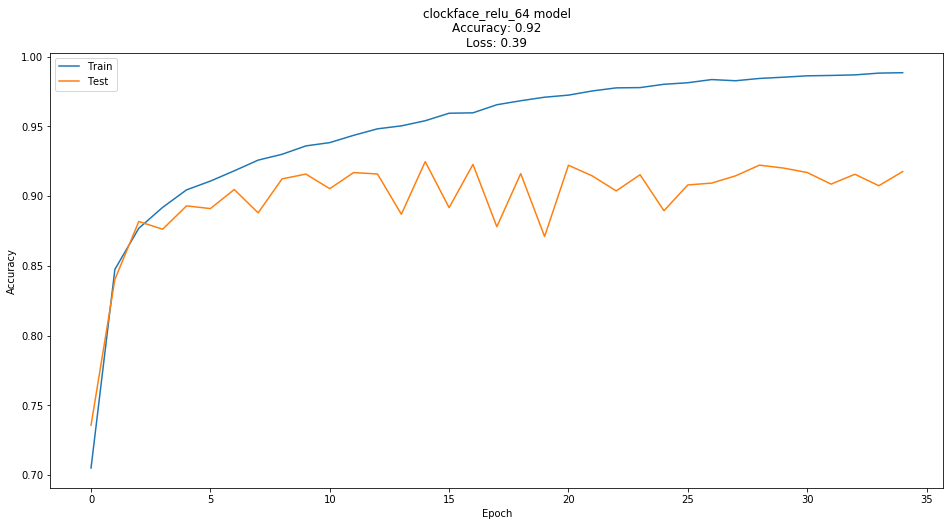

In [0]:
h,m = show_model(get_model_resnet(neurons = 128,activation = acts['Clockface']), epochs = 250, patience = 25)

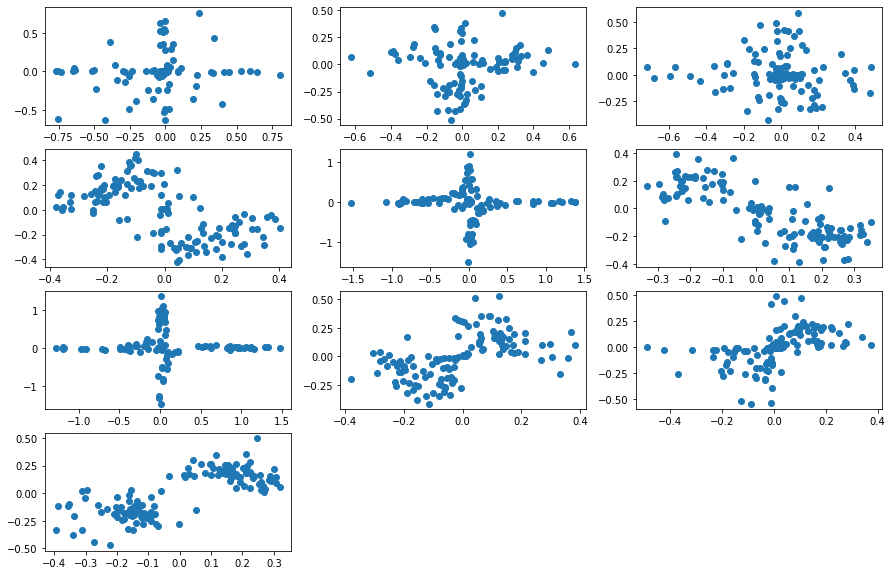

In [0]:
ls = {l.name:l for l in m.layers}
clc = [l for n,l in ls.items() if 'clockface' in n]
for i,l in enumerate(clc):
  ax = plt.subplot(4,3,i+1)
  alpha,beta = l.get_weights()
  ax.plot(alpha,beta,'o')

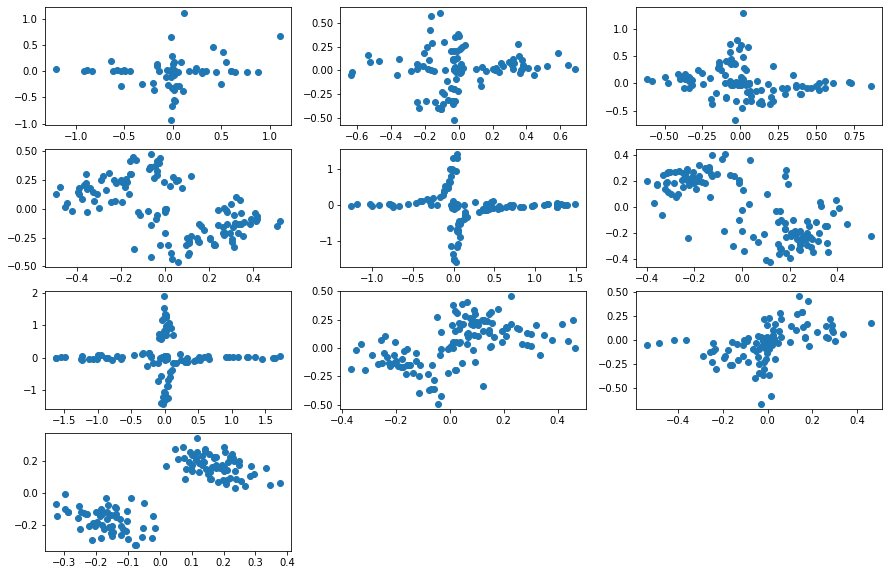

In [0]:
ls = {l.name:l for l in m.layers}
clc = [l for n,l in ls.items() if 'clockface' in n]
for i,l in enumerate(clc):
  ax = plt.subplot(4,3,i+1)
  alpha,beta = l.get_weights()
  ax.plot(alpha,beta,'o')

In [0]:
len(clc)

10

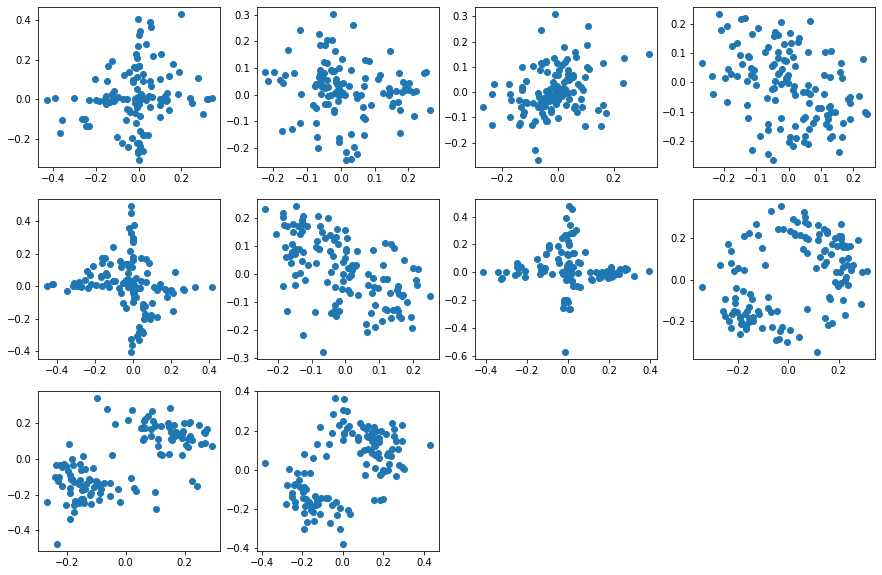

In [0]:
for i,l in enumerate(clc):
  ax = plt.subplot(4,3,i+1)
  alpha,beta = l.get_weights()
  ax.plot(alpha,beta,'o')